In [276]:
import sys
import importlib
sys.path.append('/home/ec2-user/SageMaker/Bias/')
import fairness
importlib.reload(fairness.train)

<module 'fairness.train' from '/home/ec2-user/SageMaker/Bias/fairness/train.py'>

In [277]:
from fairness.data_simulation import DataGenerator
from fairness.split_data import perform_train_test_split
from fairness.models import Encoder, Predictor, Adversary
from fairness.init_networks import initialize_networks
from fairness.data_loaders import create_dataloaders
from fairness.training_components import initialize_training_components
from fairness.train import train_model
from fairness.plots import plot_lines,plot_comparison_heatmaps, plot_auc_roc_curve
from fairness.test import get_transformed_features, get_predictions
from fairness.eval import evaluate_classifier
from fairness.fairness_metrics import get_demographic_parity
from fairness.MI import calculate_MI
from fairness.xgb_classifier import train_xgb_classifier
from fairness.xgb_optuna import objective

In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import random
import torch
import optuna
import xgboost as xgb
import warnings

In [279]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [289]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [280]:
num_non_sensitive = 4
num_sensitive = 1
# 15
generator = DataGenerator(num_non_sensitive = num_non_sensitive, num_sensitive = num_sensitive, seed=10)
data = generator.generate_simulated_data()
data.head()

,X1,X2,X3,X4,S1,Y,Y_bayes
0,-1.180952,1.725163,0.117554,0.599477,1,1,0.4162
1,-2.004398,1.485273,1.573115,1.553144,0,1,0.9779
2,-0.809262,0.326281,-0.276980,0.558294,1,0,0.5097
3,-1.417629,0.756036,0.758511,0.312607,1,1,0.7875
4,-0.549371,1.054618,-0.421361,0.375342,0,0,0.5973


In [281]:
# data = pd.read_csv('data.csv')

In [282]:
roc_auc_score(data['Y'],data['Y_bayes']) 

0.8366657236656565

In [283]:
print(data['Y'].mean() , data['Y_bayes'].mean())

0.5073 0.50539982


In [284]:
data_train, data_val, data_test = perform_train_test_split(data, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, test_size=0.15, val_size=0.1, random_state=seed)

print(data_train.shape, data_test.shape)

(7499, 6) (1500, 6)


In [285]:
X_train, Y_train = data_train[['X1', 'X2', 'X3', 'X4']], data_train[['Y']]
X_test, Y_test = data_test[['X1', 'X2', 'X3', 'X4']], data_test[['Y']]
model_before = train_xgb_classifier(X_train, Y_train, seed=seed)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:30:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [286]:
Y_pred = model_before.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_before.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.7749027109381528


In [290]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, Y_train, Y_test), n_trials=100)

[I 2024-12-04 16:32:45,228] A new study created in memory with name: no-name-72e5e3e7-9bc6-43e8-a63d-91145159ced4
[I 2024-12-04 16:32:45,411] Trial 0 finished with value: 0.8046094304167652 and parameters: {'max_depth': 3, 'learning_rate': 0.020945826715971838, 'n_estimators': 167, 'subsample': 0.9462607857084933, 'colsample_bytree': 0.8669108302983806, 'gamma': 0.08415664628606867, 'min_child_weight': 5}. Best is trial 0 with value: 0.8046094304167652.


Trial 0:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.020945826715971838, 'n_estimators': 167, 'subsample': 0.9462607857084933, 'colsample_bytree': 0.8669108302983806, 'gamma': 0.08415664628606867, 'min_child_weight': 5}
Accuracy: 0.74, Precision: 0.7409395973154362, Recall: 0.7369826435246996, F1-score: 0.7389558232931727, AUC: 0.8046094304167652
--------------------------------------------------


[I 2024-12-04 16:32:45,754] Trial 1 finished with value: 0.8074716577273915 and parameters: {'max_depth': 6, 'learning_rate': 0.012685260347400836, 'n_estimators': 182, 'subsample': 0.7753442593304359, 'colsample_bytree': 0.9129094831385032, 'gamma': 0.16187382773194497, 'min_child_weight': 6}. Best is trial 1 with value: 0.8074716577273915.
[I 2024-12-04 16:32:45,947] Trial 2 finished with value: 0.8059072105017075 and parameters: {'max_depth': 6, 'learning_rate': 0.02423794726375551, 'n_estimators': 110, 'subsample': 0.8691267243520954, 'colsample_bytree': 0.8817271632309971, 'gamma': 0.4753167236004787, 'min_child_weight': 3}. Best is trial 1 with value: 0.8074716577273915.


Trial 1:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012685260347400836, 'n_estimators': 182, 'subsample': 0.7753442593304359, 'colsample_bytree': 0.9129094831385032, 'gamma': 0.16187382773194497, 'min_child_weight': 6}
Accuracy: 0.7393333333333333, Precision: 0.7412398921832885, Recall: 0.7343124165554072, F1-score: 0.7377598926894702, AUC: 0.8074716577273915
--------------------------------------------------
Trial 2:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.02423794726375551, 'n_estimators': 110, 'subsample': 0.8691267243520954, 'colsample_bytree': 0.8817271632309971, 'gamma': 0.4753167236004787, 'min_child_weight': 3}
Accuracy: 0.74, Precision: 0.7402945113788487, Recall: 0.7383177570093458, F1-score: 0.7393048128342246, AUC: 0.8059072105017075
--------------------------------------------------


[I 2024-12-04 16:32:46,224] Trial 3 finished with value: 0.8066805452098582 and parameters: {'max_depth': 6, 'learning_rate': 0.010810635940341682, 'n_estimators': 126, 'subsample': 0.72258593867435, 'colsample_bytree': 0.9923709054720715, 'gamma': 0.22480100271455794, 'min_child_weight': 2}. Best is trial 1 with value: 0.8074716577273915.


Trial 3:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.010810635940341682, 'n_estimators': 126, 'subsample': 0.72258593867435, 'colsample_bytree': 0.9923709054720715, 'gamma': 0.22480100271455794, 'min_child_weight': 2}
Accuracy: 0.7393333333333333, Precision: 0.7386666666666667, Recall: 0.739652870493992, F1-score: 0.7391594396264176, AUC: 0.8066805452098582
--------------------------------------------------


[I 2024-12-04 16:32:46,543] Trial 4 finished with value: 0.8076725469734168 and parameters: {'max_depth': 3, 'learning_rate': 0.0255648697416395, 'n_estimators': 410, 'subsample': 0.8192588300520613, 'colsample_bytree': 0.7314002766452925, 'gamma': 0.4372562224457664, 'min_child_weight': 9}. Best is trial 4 with value: 0.8076725469734168.


Trial 4:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.0255648697416395, 'n_estimators': 410, 'subsample': 0.8192588300520613, 'colsample_bytree': 0.7314002766452925, 'gamma': 0.4372562224457664, 'min_child_weight': 9}
Accuracy: 0.74, Precision: 0.735873850197109, Recall: 0.7476635514018691, F1-score: 0.7417218543046358, AUC: 0.8076725469734168
--------------------------------------------------


[I 2024-12-04 16:32:46,763] Trial 5 finished with value: 0.804639652692716 and parameters: {'max_depth': 5, 'learning_rate': 0.05223702315684678, 'n_estimators': 197, 'subsample': 0.9923473754846353, 'colsample_bytree': 0.765094985633785, 'gamma': 0.23833470396239065, 'min_child_weight': 7}. Best is trial 4 with value: 0.8076725469734168.


Trial 5:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.05223702315684678, 'n_estimators': 197, 'subsample': 0.9923473754846353, 'colsample_bytree': 0.765094985633785, 'gamma': 0.23833470396239065, 'min_child_weight': 7}
Accuracy: 0.7366666666666667, Precision: 0.7347480106100795, Recall: 0.739652870493992, F1-score: 0.7371922821024618, AUC: 0.804639652692716
--------------------------------------------------


[I 2024-12-04 16:32:47,038] Trial 6 finished with value: 0.8006556456100367 and parameters: {'max_depth': 4, 'learning_rate': 0.1658736594615774, 'n_estimators': 338, 'subsample': 0.9799865637647573, 'colsample_bytree': 0.8516427825650354, 'gamma': 0.3222536415225576, 'min_child_weight': 9}. Best is trial 4 with value: 0.8076725469734168.


Trial 6:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.1658736594615774, 'n_estimators': 338, 'subsample': 0.9799865637647573, 'colsample_bytree': 0.8516427825650354, 'gamma': 0.3222536415225576, 'min_child_weight': 9}
Accuracy: 0.7286666666666667, Precision: 0.7292225201072386, Recall: 0.7263017356475301, F1-score: 0.7277591973244147, AUC: 0.8006556456100367
--------------------------------------------------


[I 2024-12-04 16:32:47,421] Trial 7 finished with value: 0.7960351929514541 and parameters: {'max_depth': 4, 'learning_rate': 0.07999505801452614, 'n_estimators': 417, 'subsample': 0.7444433211946585, 'colsample_bytree': 0.9776785344647364, 'gamma': 0.11584973375543522, 'min_child_weight': 4}. Best is trial 4 with value: 0.8076725469734168.


Trial 7:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.07999505801452614, 'n_estimators': 417, 'subsample': 0.7444433211946585, 'colsample_bytree': 0.9776785344647364, 'gamma': 0.11584973375543522, 'min_child_weight': 4}
Accuracy: 0.734, Precision: 0.7327127659574468, Recall: 0.7356475300400535, F1-score: 0.7341772151898734, AUC: 0.7960351929514541
--------------------------------------------------


[I 2024-12-04 16:32:47,648] Trial 8 finished with value: 0.8030680943432789 and parameters: {'max_depth': 5, 'learning_rate': 0.058889350923949674, 'n_estimators': 142, 'subsample': 0.7797264250063046, 'colsample_bytree': 0.7078951451100842, 'gamma': 0.4706918846954608, 'min_child_weight': 9}. Best is trial 4 with value: 0.8076725469734168.


Trial 8:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.058889350923949674, 'n_estimators': 142, 'subsample': 0.7797264250063046, 'colsample_bytree': 0.7078951451100842, 'gamma': 0.4706918846954608, 'min_child_weight': 9}
Accuracy: 0.7386666666666667, Precision: 0.7333333333333333, Recall: 0.7489986648865153, F1-score: 0.7410832232496698, AUC: 0.8030680943432789
--------------------------------------------------


[I 2024-12-04 16:32:48,008] Trial 9 finished with value: 0.7791373851331291 and parameters: {'max_depth': 3, 'learning_rate': 0.2514139149300101, 'n_estimators': 441, 'subsample': 0.7854902702532958, 'colsample_bytree': 0.7806921990692934, 'gamma': 0.25475801455128827, 'min_child_weight': 4}. Best is trial 4 with value: 0.8076725469734168.


Trial 9:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.2514139149300101, 'n_estimators': 441, 'subsample': 0.7854902702532958, 'colsample_bytree': 0.7806921990692934, 'gamma': 0.25475801455128827, 'min_child_weight': 4}
Accuracy: 0.722, Precision: 0.7225201072386059, Recall: 0.719626168224299, F1-score: 0.7210702341137124, AUC: 0.7791373851331291
--------------------------------------------------


[I 2024-12-04 16:32:48,231] Trial 10 finished with value: 0.8076369913546513 and parameters: {'max_depth': 3, 'learning_rate': 0.029672091380522736, 'n_estimators': 311, 'subsample': 0.8745577838285167, 'colsample_bytree': 0.706852131525498, 'gamma': 0.3722029189074039, 'min_child_weight': 10}. Best is trial 4 with value: 0.8076725469734168.


Trial 10:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.029672091380522736, 'n_estimators': 311, 'subsample': 0.8745577838285167, 'colsample_bytree': 0.706852131525498, 'gamma': 0.3722029189074039, 'min_child_weight': 10}
Accuracy: 0.7393333333333333, Precision: 0.7336814621409922, Recall: 0.7503337783711616, F1-score: 0.7419141914191419, AUC: 0.8076369913546513
--------------------------------------------------


[I 2024-12-04 16:32:48,454] Trial 11 finished with value: 0.8084049927199871 and parameters: {'max_depth': 3, 'learning_rate': 0.027714531583404985, 'n_estimators': 318, 'subsample': 0.8368246148441358, 'colsample_bytree': 0.7056722620930356, 'gamma': 0.37504424745321674, 'min_child_weight': 10}. Best is trial 11 with value: 0.8084049927199871.


Trial 11:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.027714531583404985, 'n_estimators': 318, 'subsample': 0.8368246148441358, 'colsample_bytree': 0.7056722620930356, 'gamma': 0.37504424745321674, 'min_child_weight': 10}
Accuracy: 0.7406666666666667, Precision: 0.734375, Recall: 0.753004005340454, F1-score: 0.7435728411338167, AUC: 0.8084049927199871
--------------------------------------------------


[I 2024-12-04 16:32:48,763] Trial 12 finished with value: 0.8055516543140522 and parameters: {'max_depth': 4, 'learning_rate': 0.03456085979562303, 'n_estimators': 381, 'subsample': 0.827467957277055, 'colsample_bytree': 0.7842730468555057, 'gamma': 0.3845729973485027, 'min_child_weight': 8}. Best is trial 11 with value: 0.8084049927199871.


Trial 12:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03456085979562303, 'n_estimators': 381, 'subsample': 0.827467957277055, 'colsample_bytree': 0.7842730468555057, 'gamma': 0.3845729973485027, 'min_child_weight': 8}
Accuracy: 0.7406666666666667, Precision: 0.7380952380952381, Recall: 0.7449933244325768, F1-score: 0.7415282392026578, AUC: 0.8055516543140522
--------------------------------------------------


[I 2024-12-04 16:32:49,076] Trial 13 finished with value: 0.80920677192315 and parameters: {'max_depth': 3, 'learning_rate': 0.01629699316886312, 'n_estimators': 495, 'subsample': 0.9053655749129627, 'colsample_bytree': 0.7372195746422753, 'gamma': 0.4118810416173006, 'min_child_weight': 10}. Best is trial 13 with value: 0.80920677192315.


Trial 13:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01629699316886312, 'n_estimators': 495, 'subsample': 0.9053655749129627, 'colsample_bytree': 0.7372195746422753, 'gamma': 0.4118810416173006, 'min_child_weight': 10}
Accuracy: 0.7446666666666667, Precision: 0.73828125, Recall: 0.7570093457943925, F1-score: 0.7475280158206987, AUC: 0.80920677192315
--------------------------------------------------


[I 2024-12-04 16:32:49,445] Trial 14 finished with value: 0.8083356592633941 and parameters: {'max_depth': 4, 'learning_rate': 0.01594503541114165, 'n_estimators': 491, 'subsample': 0.9117151369219054, 'colsample_bytree': 0.80719091321352, 'gamma': 0.3304771901451913, 'min_child_weight': 10}. Best is trial 13 with value: 0.80920677192315.


Trial 14:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01594503541114165, 'n_estimators': 491, 'subsample': 0.9117151369219054, 'colsample_bytree': 0.80719091321352, 'gamma': 0.3304771901451913, 'min_child_weight': 10}
Accuracy: 0.7386666666666667, Precision: 0.7345597897503285, Recall: 0.7463284379172229, F1-score: 0.7403973509933774, AUC: 0.8083356592633941
--------------------------------------------------


[I 2024-12-04 16:32:49,651] Trial 15 finished with value: 0.808225436845221 and parameters: {'max_depth': 3, 'learning_rate': 0.04251502102863278, 'n_estimators': 241, 'subsample': 0.9024544725237067, 'colsample_bytree': 0.7458605977971916, 'gamma': 0.00898077569000627, 'min_child_weight': 7}. Best is trial 13 with value: 0.80920677192315.


Trial 15:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.04251502102863278, 'n_estimators': 241, 'subsample': 0.9024544725237067, 'colsample_bytree': 0.7458605977971916, 'gamma': 0.00898077569000627, 'min_child_weight': 7}
Accuracy: 0.7406666666666667, Precision: 0.734375, Recall: 0.753004005340454, F1-score: 0.7435728411338167, AUC: 0.808225436845221
--------------------------------------------------


[I 2024-12-04 16:32:49,923] Trial 16 finished with value: 0.8033560948552797 and parameters: {'max_depth': 3, 'learning_rate': 0.07514480847231614, 'n_estimators': 251, 'subsample': 0.9241089144855792, 'colsample_bytree': 0.8120646248535128, 'gamma': 0.4109193790456806, 'min_child_weight': 10}. Best is trial 13 with value: 0.80920677192315.


Trial 16:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.07514480847231614, 'n_estimators': 251, 'subsample': 0.9241089144855792, 'colsample_bytree': 0.8120646248535128, 'gamma': 0.4109193790456806, 'min_child_weight': 10}
Accuracy: 0.7346666666666667, Precision: 0.7300131061598951, Recall: 0.7436582109479306, F1-score: 0.7367724867724867, AUC: 0.8033560948552797
--------------------------------------------------


[I 2024-12-04 16:32:50,372] Trial 17 finished with value: 0.8044956524367155 and parameters: {'max_depth': 5, 'learning_rate': 0.01692407963614665, 'n_estimators': 481, 'subsample': 0.8315518890749752, 'colsample_bytree': 0.7352327151279712, 'gamma': 0.3115339553955812, 'min_child_weight': 1}. Best is trial 13 with value: 0.80920677192315.


Trial 17:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01692407963614665, 'n_estimators': 481, 'subsample': 0.8315518890749752, 'colsample_bytree': 0.7352327151279712, 'gamma': 0.3115339553955812, 'min_child_weight': 1}
Accuracy: 0.74, Precision: 0.735873850197109, Recall: 0.7476635514018691, F1-score: 0.7417218543046358, AUC: 0.8044956524367155
--------------------------------------------------


[I 2024-12-04 16:32:50,676] Trial 18 finished with value: 0.7962680822543685 and parameters: {'max_depth': 4, 'learning_rate': 0.11286105626576724, 'n_estimators': 360, 'subsample': 0.8698970824099297, 'colsample_bytree': 0.817392361578085, 'gamma': 0.498148714752363, 'min_child_weight': 8}. Best is trial 13 with value: 0.80920677192315.


Trial 18:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.11286105626576724, 'n_estimators': 360, 'subsample': 0.8698970824099297, 'colsample_bytree': 0.817392361578085, 'gamma': 0.498148714752363, 'min_child_weight': 8}
Accuracy: 0.7266666666666667, Precision: 0.7250996015936255, Recall: 0.7289719626168224, F1-score: 0.7270306258322237, AUC: 0.7962680822543685
--------------------------------------------------


[I 2024-12-04 16:32:50,899] Trial 19 finished with value: 0.8058938771446704 and parameters: {'max_depth': 3, 'learning_rate': 0.016561490801917135, 'n_estimators': 269, 'subsample': 0.9364627790295812, 'colsample_bytree': 0.7015346117395743, 'gamma': 0.3648171151196652, 'min_child_weight': 8}. Best is trial 13 with value: 0.80920677192315.


Trial 19:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.016561490801917135, 'n_estimators': 269, 'subsample': 0.9364627790295812, 'colsample_bytree': 0.7015346117395743, 'gamma': 0.3648171151196652, 'min_child_weight': 8}
Accuracy: 0.742, Precision: 0.7387862796833773, Recall: 0.7476635514018691, F1-score: 0.7431984074319841, AUC: 0.8058938771446704
--------------------------------------------------


[I 2024-12-04 16:32:51,263] Trial 20 finished with value: 0.804506319122345 and parameters: {'max_depth': 4, 'learning_rate': 0.03417627585599432, 'n_estimators': 447, 'subsample': 0.9559178267158408, 'colsample_bytree': 0.9287167763832384, 'gamma': 0.28077611060129376, 'min_child_weight': 6}. Best is trial 13 with value: 0.80920677192315.


Trial 20:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03417627585599432, 'n_estimators': 447, 'subsample': 0.9559178267158408, 'colsample_bytree': 0.9287167763832384, 'gamma': 0.28077611060129376, 'min_child_weight': 6}
Accuracy: 0.7393333333333333, Precision: 0.7361477572559367, Recall: 0.7449933244325768, F1-score: 0.7405441274054413, AUC: 0.804506319122345
--------------------------------------------------


[I 2024-12-04 16:32:51,751] Trial 21 finished with value: 0.8082805480543076 and parameters: {'max_depth': 4, 'learning_rate': 0.016054621128447258, 'n_estimators': 496, 'subsample': 0.8924867198285692, 'colsample_bytree': 0.8131109685996669, 'gamma': 0.3295069427990573, 'min_child_weight': 10}. Best is trial 13 with value: 0.80920677192315.


Trial 21:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.016054621128447258, 'n_estimators': 496, 'subsample': 0.8924867198285692, 'colsample_bytree': 0.8131109685996669, 'gamma': 0.3295069427990573, 'min_child_weight': 10}
Accuracy: 0.7413333333333333, Precision: 0.7359477124183007, Recall: 0.7516688918558078, F1-score: 0.7437252311756936, AUC: 0.8082805480543076
--------------------------------------------------


[I 2024-12-04 16:32:52,090] Trial 22 finished with value: 0.8085116595762838 and parameters: {'max_depth': 3, 'learning_rate': 0.012805791538933329, 'n_estimators': 467, 'subsample': 0.9078568343769842, 'colsample_bytree': 0.7641327432648528, 'gamma': 0.43679641707042083, 'min_child_weight': 10}. Best is trial 13 with value: 0.80920677192315.


Trial 22:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.012805791538933329, 'n_estimators': 467, 'subsample': 0.9078568343769842, 'colsample_bytree': 0.7641327432648528, 'gamma': 0.43679641707042083, 'min_child_weight': 10}
Accuracy: 0.7433333333333333, Precision: 0.7401055408970977, Recall: 0.7489986648865153, F1-score: 0.7445255474452555, AUC: 0.8085116595762838
--------------------------------------------------


[I 2024-12-04 16:32:52,448] Trial 23 finished with value: 0.8088049934310994 and parameters: {'max_depth': 3, 'learning_rate': 0.01051191921566217, 'n_estimators': 441, 'subsample': 0.8392370095909505, 'colsample_bytree': 0.7526572076851874, 'gamma': 0.43427462563098296, 'min_child_weight': 9}. Best is trial 13 with value: 0.80920677192315.


Trial 23:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01051191921566217, 'n_estimators': 441, 'subsample': 0.8392370095909505, 'colsample_bytree': 0.7526572076851874, 'gamma': 0.43427462563098296, 'min_child_weight': 9}
Accuracy: 0.7406666666666667, Precision: 0.737467018469657, Recall: 0.7463284379172229, F1-score: 0.7418712674187127, AUC: 0.8088049934310994
--------------------------------------------------


[I 2024-12-04 16:32:52,841] Trial 24 finished with value: 0.8096281060055219 and parameters: {'max_depth': 3, 'learning_rate': 0.013330089390867026, 'n_estimators': 461, 'subsample': 0.851892906268579, 'colsample_bytree': 0.7585191676968733, 'gamma': 0.43632459175355576, 'min_child_weight': 9}. Best is trial 24 with value: 0.8096281060055219.


Trial 24:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.013330089390867026, 'n_estimators': 461, 'subsample': 0.851892906268579, 'colsample_bytree': 0.7585191676968733, 'gamma': 0.43632459175355576, 'min_child_weight': 9}
Accuracy: 0.7413333333333333, Precision: 0.7378129117259552, Recall: 0.7476635514018691, F1-score: 0.7427055702917772, AUC: 0.8096281060055219
--------------------------------------------------


[I 2024-12-04 16:32:53,185] Trial 25 finished with value: 0.807012990245316 and parameters: {'max_depth': 3, 'learning_rate': 0.010468484608871143, 'n_estimators': 399, 'subsample': 0.8069252171171566, 'colsample_bytree': 0.7424165184416349, 'gamma': 0.4324243885128178, 'min_child_weight': 7}. Best is trial 24 with value: 0.8096281060055219.


Trial 25:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.010468484608871143, 'n_estimators': 399, 'subsample': 0.8069252171171566, 'colsample_bytree': 0.7424165184416349, 'gamma': 0.4324243885128178, 'min_child_weight': 7}
Accuracy: 0.7393333333333333, Precision: 0.7386666666666667, Recall: 0.739652870493992, F1-score: 0.7391594396264176, AUC: 0.807012990245316
--------------------------------------------------


[I 2024-12-04 16:32:53,480] Trial 26 finished with value: 0.8097472173283864 and parameters: {'max_depth': 3, 'learning_rate': 0.019848425080214286, 'n_estimators': 441, 'subsample': 0.8531819870330701, 'colsample_bytree': 0.7837299017633881, 'gamma': 0.4062990950623118, 'min_child_weight': 9}. Best is trial 26 with value: 0.8097472173283864.


Trial 26:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.019848425080214286, 'n_estimators': 441, 'subsample': 0.8531819870330701, 'colsample_bytree': 0.7837299017633881, 'gamma': 0.4062990950623118, 'min_child_weight': 9}
Accuracy: 0.7433333333333333, Precision: 0.7363636363636363, Recall: 0.7570093457943925, F1-score: 0.7465437788018433, AUC: 0.8097472173283864
--------------------------------------------------


[I 2024-12-04 16:32:53,845] Trial 27 finished with value: 0.8083747704440364 and parameters: {'max_depth': 4, 'learning_rate': 0.020606789082805978, 'n_estimators': 456, 'subsample': 0.8581808744137236, 'colsample_bytree': 0.7840630131938282, 'gamma': 0.49816461972427306, 'min_child_weight': 8}. Best is trial 26 with value: 0.8097472173283864.


Trial 27:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.020606789082805978, 'n_estimators': 456, 'subsample': 0.8581808744137236, 'colsample_bytree': 0.7840630131938282, 'gamma': 0.49816461972427306, 'min_child_weight': 8}
Accuracy: 0.7426666666666667, Precision: 0.7385019710906702, Recall: 0.7503337783711616, F1-score: 0.7443708609271523, AUC: 0.8083747704440364
--------------------------------------------------


[I 2024-12-04 16:32:54,095] Trial 28 finished with value: 0.8091196606571746 and parameters: {'max_depth': 3, 'learning_rate': 0.019170510907251262, 'n_estimators': 363, 'subsample': 0.881505495032812, 'colsample_bytree': 0.8406267933464738, 'gamma': 0.40631778746066755, 'min_child_weight': 9}. Best is trial 26 with value: 0.8097472173283864.


Trial 28:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.019170510907251262, 'n_estimators': 363, 'subsample': 0.881505495032812, 'colsample_bytree': 0.8406267933464738, 'gamma': 0.40631778746066755, 'min_child_weight': 9}
Accuracy: 0.744, Precision: 0.738562091503268, Recall: 0.7543391188251002, F1-score: 0.7463672391017173, AUC: 0.8091196606571746
--------------------------------------------------


[I 2024-12-04 16:32:54,438] Trial 29 finished with value: 0.8085187707000369 and parameters: {'max_depth': 3, 'learning_rate': 0.02343357772140584, 'n_estimators': 425, 'subsample': 0.9607989489757168, 'colsample_bytree': 0.7258943759327742, 'gamma': 0.20856490504892458, 'min_child_weight': 5}. Best is trial 26 with value: 0.8097472173283864.


Trial 29:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02343357772140584, 'n_estimators': 425, 'subsample': 0.9607989489757168, 'colsample_bytree': 0.7258943759327742, 'gamma': 0.20856490504892458, 'min_child_weight': 5}
Accuracy: 0.744, Precision: 0.7391874180865007, Recall: 0.753004005340454, F1-score: 0.746031746031746, AUC: 0.8085187707000369
--------------------------------------------------


[I 2024-12-04 16:32:55,176] Trial 30 finished with value: 0.8076832136590465 and parameters: {'max_depth': 5, 'learning_rate': 0.013532057838011315, 'n_estimators': 497, 'subsample': 0.7951449343167473, 'colsample_bytree': 0.7937392662247182, 'gamma': 0.2938962295088443, 'min_child_weight': 7}. Best is trial 26 with value: 0.8097472173283864.


Trial 30:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.013532057838011315, 'n_estimators': 497, 'subsample': 0.7951449343167473, 'colsample_bytree': 0.7937392662247182, 'gamma': 0.2938962295088443, 'min_child_weight': 7}
Accuracy: 0.7406666666666667, Precision: 0.7393617021276596, Recall: 0.7423230974632844, F1-score: 0.7408394403730846, AUC: 0.8076832136590465
--------------------------------------------------


[I 2024-12-04 16:32:55,547] Trial 31 finished with value: 0.8093241054650764 and parameters: {'max_depth': 3, 'learning_rate': 0.020290600821243964, 'n_estimators': 377, 'subsample': 0.8827226642556787, 'colsample_bytree': 0.8429330763620597, 'gamma': 0.4089757196875699, 'min_child_weight': 9}. Best is trial 26 with value: 0.8097472173283864.


Trial 31:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.020290600821243964, 'n_estimators': 377, 'subsample': 0.8827226642556787, 'colsample_bytree': 0.8429330763620597, 'gamma': 0.4089757196875699, 'min_child_weight': 9}
Accuracy: 0.746, Precision: 0.7402088772845953, Recall: 0.7570093457943925, F1-score: 0.7485148514851485, AUC: 0.8093241054650764
--------------------------------------------------


[I 2024-12-04 16:32:55,870] Trial 32 finished with value: 0.8095374391776696 and parameters: {'max_depth': 3, 'learning_rate': 0.019540125257073125, 'n_estimators': 466, 'subsample': 0.8520322909450585, 'colsample_bytree': 0.8796091346156925, 'gamma': 0.3471929950102919, 'min_child_weight': 9}. Best is trial 26 with value: 0.8097472173283864.


Trial 32:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.019540125257073125, 'n_estimators': 466, 'subsample': 0.8520322909450585, 'colsample_bytree': 0.8796091346156925, 'gamma': 0.3471929950102919, 'min_child_weight': 9}
Accuracy: 0.7446666666666667, Precision: 0.7389033942558747, Recall: 0.7556742323097463, F1-score: 0.7471947194719472, AUC: 0.8095374391776696
--------------------------------------------------


[I 2024-12-04 16:32:56,147] Trial 33 finished with value: 0.8099978844406834 and parameters: {'max_depth': 3, 'learning_rate': 0.019241250589552047, 'n_estimators': 399, 'subsample': 0.8539896723720624, 'colsample_bytree': 0.8838946070726277, 'gamma': 0.461072226560526, 'min_child_weight': 8}. Best is trial 33 with value: 0.8099978844406834.


Trial 33:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.019241250589552047, 'n_estimators': 399, 'subsample': 0.8539896723720624, 'colsample_bytree': 0.8838946070726277, 'gamma': 0.461072226560526, 'min_child_weight': 8}
Accuracy: 0.744, Precision: 0.738562091503268, Recall: 0.7543391188251002, F1-score: 0.7463672391017173, AUC: 0.8099978844406834
--------------------------------------------------


[I 2024-12-04 16:32:56,488] Trial 34 finished with value: 0.8063409890506472 and parameters: {'max_depth': 3, 'learning_rate': 0.040158169005078966, 'n_estimators': 460, 'subsample': 0.8535691951502399, 'colsample_bytree': 0.8957965364715514, 'gamma': 0.46384474396913866, 'min_child_weight': 8}. Best is trial 33 with value: 0.8099978844406834.


Trial 34:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.040158169005078966, 'n_estimators': 460, 'subsample': 0.8535691951502399, 'colsample_bytree': 0.8957965364715514, 'gamma': 0.46384474396913866, 'min_child_weight': 8}
Accuracy: 0.74, Precision: 0.7364953886693018, Recall: 0.7463284379172229, F1-score: 0.7413793103448276, AUC: 0.8063409890506472
--------------------------------------------------


[I 2024-12-04 16:32:56,793] Trial 35 finished with value: 0.8089916604296186 and parameters: {'max_depth': 3, 'learning_rate': 0.01315909708111451, 'n_estimators': 398, 'subsample': 0.76335081437757, 'colsample_bytree': 0.937981849253285, 'gamma': 0.3533925640301997, 'min_child_weight': 8}. Best is trial 33 with value: 0.8099978844406834.


Trial 35:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01315909708111451, 'n_estimators': 398, 'subsample': 0.76335081437757, 'colsample_bytree': 0.937981849253285, 'gamma': 0.3533925640301997, 'min_child_weight': 8}
Accuracy: 0.742, Precision: 0.7381578947368421, Recall: 0.7489986648865153, F1-score: 0.7435387673956262, AUC: 0.8089916604296186
--------------------------------------------------


[I 2024-12-04 16:32:57,416] Trial 36 finished with value: 0.8041614296203193 and parameters: {'max_depth': 6, 'learning_rate': 0.023459423241569917, 'n_estimators': 426, 'subsample': 0.8508174415427296, 'colsample_bytree': 0.8956775615217886, 'gamma': 0.4684497291551356, 'min_child_weight': 6}. Best is trial 33 with value: 0.8099978844406834.


Trial 36:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.023459423241569917, 'n_estimators': 426, 'subsample': 0.8508174415427296, 'colsample_bytree': 0.8956775615217886, 'gamma': 0.4684497291551356, 'min_child_weight': 6}
Accuracy: 0.7406666666666667, Precision: 0.7406417112299465, Recall: 0.739652870493992, F1-score: 0.7401469605878424, AUC: 0.8041614296203193
--------------------------------------------------


[I 2024-12-04 16:32:57,671] Trial 37 finished with value: 0.8066325451245246 and parameters: {'max_depth': 4, 'learning_rate': 0.029577721205300587, 'n_estimators': 348, 'subsample': 0.8148466833598592, 'colsample_bytree': 0.8710256466382738, 'gamma': 0.44839337994894196, 'min_child_weight': 9}. Best is trial 33 with value: 0.8099978844406834.


Trial 37:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.029577721205300587, 'n_estimators': 348, 'subsample': 0.8148466833598592, 'colsample_bytree': 0.8710256466382738, 'gamma': 0.44839337994894196, 'min_child_weight': 9}
Accuracy: 0.7373333333333333, Precision: 0.7326343381389253, Recall: 0.7463284379172229, F1-score: 0.7394179894179894, AUC: 0.8066325451245246
--------------------------------------------------


[I 2024-12-04 16:32:57,909] Trial 38 finished with value: 0.8092458831037921 and parameters: {'max_depth': 3, 'learning_rate': 0.013126883547612562, 'n_estimators': 391, 'subsample': 0.806043294752788, 'colsample_bytree': 0.9166748615856555, 'gamma': 0.17182982468169258, 'min_child_weight': 7}. Best is trial 33 with value: 0.8099978844406834.


Trial 38:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.013126883547612562, 'n_estimators': 391, 'subsample': 0.806043294752788, 'colsample_bytree': 0.9166748615856555, 'gamma': 0.17182982468169258, 'min_child_weight': 7}
Accuracy: 0.7426666666666667, Precision: 0.7391304347826086, Recall: 0.7489986648865153, F1-score: 0.7440318302387268, AUC: 0.8092458831037921
--------------------------------------------------


[I 2024-12-04 16:32:58,211] Trial 39 finished with value: 0.7999285332062812 and parameters: {'max_depth': 4, 'learning_rate': 0.052758471426144586, 'n_estimators': 471, 'subsample': 0.8622952443585423, 'colsample_bytree': 0.9575735934115768, 'gamma': 0.3401925859833135, 'min_child_weight': 9}. Best is trial 33 with value: 0.8099978844406834.


Trial 39:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.052758471426144586, 'n_estimators': 471, 'subsample': 0.8622952443585423, 'colsample_bytree': 0.9575735934115768, 'gamma': 0.3401925859833135, 'min_child_weight': 9}
Accuracy: 0.7353333333333333, Precision: 0.7328042328042328, Recall: 0.739652870493992, F1-score: 0.7362126245847176, AUC: 0.7999285332062812
--------------------------------------------------


[I 2024-12-04 16:32:58,457] Trial 40 finished with value: 0.8097596617949543 and parameters: {'max_depth': 3, 'learning_rate': 0.01887360267217804, 'n_estimators': 415, 'subsample': 0.8473980923178888, 'colsample_bytree': 0.8547872937862235, 'gamma': 0.38567403545207407, 'min_child_weight': 6}. Best is trial 33 with value: 0.8099978844406834.


Trial 40:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01887360267217804, 'n_estimators': 415, 'subsample': 0.8473980923178888, 'colsample_bytree': 0.8547872937862235, 'gamma': 0.38567403545207407, 'min_child_weight': 6}
Accuracy: 0.7433333333333333, Precision: 0.7382198952879581, Recall: 0.753004005340454, F1-score: 0.7455386649041639, AUC: 0.8097596617949543
--------------------------------------------------


[I 2024-12-04 16:32:58,723] Trial 41 finished with value: 0.8100761068019676 and parameters: {'max_depth': 3, 'learning_rate': 0.018852563806763468, 'n_estimators': 421, 'subsample': 0.8426693122581937, 'colsample_bytree': 0.8606022015578495, 'gamma': 0.3931781287003237, 'min_child_weight': 4}. Best is trial 41 with value: 0.8100761068019676.


Trial 41:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.018852563806763468, 'n_estimators': 421, 'subsample': 0.8426693122581937, 'colsample_bytree': 0.8606022015578495, 'gamma': 0.3931781287003237, 'min_child_weight': 4}
Accuracy: 0.7433333333333333, Precision: 0.7369791666666666, Recall: 0.7556742323097463, F1-score: 0.7462096242584048, AUC: 0.8100761068019676
--------------------------------------------------


[I 2024-12-04 16:32:58,968] Trial 42 finished with value: 0.8086769932035434 and parameters: {'max_depth': 3, 'learning_rate': 0.024466563751690526, 'n_estimators': 416, 'subsample': 0.8360672123663292, 'colsample_bytree': 0.8593832590405742, 'gamma': 0.3915144041414031, 'min_child_weight': 3}. Best is trial 41 with value: 0.8100761068019676.


Trial 42:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.024466563751690526, 'n_estimators': 416, 'subsample': 0.8360672123663292, 'colsample_bytree': 0.8593832590405742, 'gamma': 0.3915144041414031, 'min_child_weight': 3}
Accuracy: 0.742, Precision: 0.7356770833333334, Recall: 0.7543391188251002, F1-score: 0.7448912326961108, AUC: 0.8086769932035434
--------------------------------------------------


[I 2024-12-04 16:32:59,221] Trial 43 finished with value: 0.8098254396896705 and parameters: {'max_depth': 3, 'learning_rate': 0.014454428879340555, 'n_estimators': 430, 'subsample': 0.8191478576547201, 'colsample_bytree': 0.8324098564143027, 'gamma': 0.45503692860527944, 'min_child_weight': 5}. Best is trial 41 with value: 0.8100761068019676.


Trial 43:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.014454428879340555, 'n_estimators': 430, 'subsample': 0.8191478576547201, 'colsample_bytree': 0.8324098564143027, 'gamma': 0.45503692860527944, 'min_child_weight': 5}
Accuracy: 0.7426666666666667, Precision: 0.7397622192866579, Recall: 0.7476635514018691, F1-score: 0.7436918990703851, AUC: 0.8098254396896705
--------------------------------------------------


[I 2024-12-04 16:32:59,478] Trial 44 finished with value: 0.8063889891359808 and parameters: {'max_depth': 3, 'learning_rate': 0.034895572717931186, 'n_estimators': 435, 'subsample': 0.7606237303585865, 'colsample_bytree': 0.8297124753052724, 'gamma': 0.47164670423111943, 'min_child_weight': 5}. Best is trial 41 with value: 0.8100761068019676.


Trial 44:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.034895572717931186, 'n_estimators': 435, 'subsample': 0.7606237303585865, 'colsample_bytree': 0.8297124753052724, 'gamma': 0.47164670423111943, 'min_child_weight': 5}
Accuracy: 0.74, Precision: 0.7371202113606341, Recall: 0.7449933244325768, F1-score: 0.7410358565737052, AUC: 0.8063889891359808
--------------------------------------------------


[I 2024-12-04 16:32:59,749] Trial 45 finished with value: 0.8093205499031998 and parameters: {'max_depth': 3, 'learning_rate': 0.017914150591920138, 'n_estimators': 325, 'subsample': 0.8230566697776313, 'colsample_bytree': 0.8641095455501081, 'gamma': 0.3873994804948326, 'min_child_weight': 4}. Best is trial 41 with value: 0.8100761068019676.


Trial 45:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.017914150591920138, 'n_estimators': 325, 'subsample': 0.8230566697776313, 'colsample_bytree': 0.8641095455501081, 'gamma': 0.3873994804948326, 'min_child_weight': 4}
Accuracy: 0.7426666666666667, Precision: 0.7391304347826086, Recall: 0.7489986648865153, F1-score: 0.7440318302387268, AUC: 0.8093205499031998
--------------------------------------------------


[I 2024-12-04 16:33:00,001] Trial 46 finished with value: 0.8092014385803352 and parameters: {'max_depth': 3, 'learning_rate': 0.014782875568760475, 'n_estimators': 408, 'subsample': 0.7237381160611303, 'colsample_bytree': 0.8995054396470694, 'gamma': 0.4547689122562424, 'min_child_weight': 3}. Best is trial 41 with value: 0.8100761068019676.


Trial 46:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.014782875568760475, 'n_estimators': 408, 'subsample': 0.7237381160611303, 'colsample_bytree': 0.8995054396470694, 'gamma': 0.4547689122562424, 'min_child_weight': 3}
Accuracy: 0.7426666666666667, Precision: 0.7378768020969856, Recall: 0.7516688918558078, F1-score: 0.7447089947089947, AUC: 0.8092014385803352
--------------------------------------------------


[I 2024-12-04 16:33:00,279] Trial 47 finished with value: 0.8075036577842805 and parameters: {'max_depth': 4, 'learning_rate': 0.023332165888914243, 'n_estimators': 379, 'subsample': 0.8014266968870674, 'colsample_bytree': 0.8269675404970446, 'gamma': 0.48818999029806237, 'min_child_weight': 5}. Best is trial 41 with value: 0.8100761068019676.
[I 2024-12-04 16:33:00,477] Trial 48 finished with value: 0.7859240638650024 and parameters: {'max_depth': 3, 'learning_rate': 0.2945538436060732, 'n_estimators': 300, 'subsample': 0.7888169688735163, 'colsample_bytree': 0.8518587589588412, 'gamma': 0.08087255529307574, 'min_child_weight': 4}. Best is trial 41 with value: 0.8100761068019676.


Trial 47:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.023332165888914243, 'n_estimators': 379, 'subsample': 0.8014266968870674, 'colsample_bytree': 0.8269675404970446, 'gamma': 0.48818999029806237, 'min_child_weight': 5}
Accuracy: 0.7373333333333333, Precision: 0.7332457293035479, Recall: 0.7449933244325768, F1-score: 0.7390728476821192, AUC: 0.8075036577842805
--------------------------------------------------
Trial 48:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.2945538436060732, 'n_estimators': 300, 'subsample': 0.7888169688735163, 'colsample_bytree': 0.8518587589588412, 'gamma': 0.08087255529307574, 'min_child_weight': 4}
Accuracy: 0.7153333333333334, Precision: 0.7158176943699732, Recall: 0.7129506008010681, F1-score: 0.7143812709030101, AUC: 0.7859240638650024
--------------------------------------------------


[I 2024-12-04 16:33:00,708] Trial 49 finished with value: 0.8086103264183581 and parameters: {'max_depth': 5, 'learning_rate': 0.011401699460131896, 'n_estimators': 197, 'subsample': 0.8172618245610908, 'colsample_bytree': 0.8769407555246453, 'gamma': 0.42403339051580735, 'min_child_weight': 6}. Best is trial 41 with value: 0.8100761068019676.


Trial 49:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.011401699460131896, 'n_estimators': 197, 'subsample': 0.8172618245610908, 'colsample_bytree': 0.8769407555246453, 'gamma': 0.42403339051580735, 'min_child_weight': 6}
Accuracy: 0.74, Precision: 0.739652870493992, Recall: 0.739652870493992, F1-score: 0.739652870493992, AUC: 0.8086103264183581
--------------------------------------------------


[I 2024-12-04 16:33:00,933] Trial 50 finished with value: 0.8082609924639864 and parameters: {'max_depth': 3, 'learning_rate': 0.027029664473934737, 'n_estimators': 362, 'subsample': 0.84119480887897, 'colsample_bytree': 0.8307571027365837, 'gamma': 0.26221804182497327, 'min_child_weight': 4}. Best is trial 41 with value: 0.8100761068019676.


Trial 50:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.027029664473934737, 'n_estimators': 362, 'subsample': 0.84119480887897, 'colsample_bytree': 0.8307571027365837, 'gamma': 0.26221804182497327, 'min_child_weight': 4}
Accuracy: 0.7386666666666667, Precision: 0.7315175097276264, Recall: 0.753004005340454, F1-score: 0.7421052631578947, AUC: 0.8082609924639864
--------------------------------------------------


[I 2024-12-04 16:33:01,196] Trial 51 finished with value: 0.8086378820229013 and parameters: {'max_depth': 3, 'learning_rate': 0.01506703800254263, 'n_estimators': 432, 'subsample': 0.8703355258546173, 'colsample_bytree': 0.7631108799930937, 'gamma': 0.44939300004004684, 'min_child_weight': 2}. Best is trial 41 with value: 0.8100761068019676.


Trial 51:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01506703800254263, 'n_estimators': 432, 'subsample': 0.8703355258546173, 'colsample_bytree': 0.7631108799930937, 'gamma': 0.44939300004004684, 'min_child_weight': 2}
Accuracy: 0.7426666666666667, Precision: 0.7378768020969856, Recall: 0.7516688918558078, F1-score: 0.7447089947089947, AUC: 0.8086378820229013
--------------------------------------------------


[I 2024-12-04 16:33:01,467] Trial 52 finished with value: 0.8089596603727295 and parameters: {'max_depth': 3, 'learning_rate': 0.012230348844331523, 'n_estimators': 449, 'subsample': 0.8914688194128852, 'colsample_bytree': 0.7978277224120394, 'gamma': 0.3921371600853193, 'min_child_weight': 5}. Best is trial 41 with value: 0.8100761068019676.


Trial 52:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.012230348844331523, 'n_estimators': 449, 'subsample': 0.8914688194128852, 'colsample_bytree': 0.7978277224120394, 'gamma': 0.3921371600853193, 'min_child_weight': 5}
Accuracy: 0.742, Precision: 0.7387862796833773, Recall: 0.7476635514018691, F1-score: 0.7431984074319841, AUC: 0.8089596603727295
--------------------------------------------------


[I 2024-12-04 16:33:01,722] Trial 53 finished with value: 0.8076121024215153 and parameters: {'max_depth': 3, 'learning_rate': 0.010086099358092947, 'n_estimators': 411, 'subsample': 0.8441506361846156, 'colsample_bytree': 0.8517089777006286, 'gamma': 0.3621812519570516, 'min_child_weight': 6}. Best is trial 41 with value: 0.8100761068019676.


Trial 53:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.010086099358092947, 'n_estimators': 411, 'subsample': 0.8441506361846156, 'colsample_bytree': 0.8517089777006286, 'gamma': 0.3621812519570516, 'min_child_weight': 6}
Accuracy: 0.7393333333333333, Precision: 0.7374005305039788, Recall: 0.7423230974632844, F1-score: 0.739853626081171, AUC: 0.8076121024215153
--------------------------------------------------


[I 2024-12-04 16:33:02,000] Trial 54 finished with value: 0.8090361049530754 and parameters: {'max_depth': 3, 'learning_rate': 0.018034415232819137, 'n_estimators': 480, 'subsample': 0.8292696653228271, 'colsample_bytree': 0.7777572516002556, 'gamma': 0.4209428934305701, 'min_child_weight': 5}. Best is trial 41 with value: 0.8100761068019676.


Trial 54:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.018034415232819137, 'n_estimators': 480, 'subsample': 0.8292696653228271, 'colsample_bytree': 0.7777572516002556, 'gamma': 0.4209428934305701, 'min_child_weight': 5}
Accuracy: 0.7413333333333333, Precision: 0.7359477124183007, Recall: 0.7516688918558078, F1-score: 0.7437252311756936, AUC: 0.8090361049530754
--------------------------------------------------


[I 2024-12-04 16:33:02,246] Trial 55 finished with value: 0.8088698824353466 and parameters: {'max_depth': 3, 'learning_rate': 0.014403503005545644, 'n_estimators': 390, 'subsample': 0.8659775052784653, 'colsample_bytree': 0.8905888516038609, 'gamma': 0.4792424720374477, 'min_child_weight': 3}. Best is trial 41 with value: 0.8100761068019676.


Trial 55:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.014403503005545644, 'n_estimators': 390, 'subsample': 0.8659775052784653, 'colsample_bytree': 0.8905888516038609, 'gamma': 0.4792424720374477, 'min_child_weight': 3}
Accuracy: 0.742, Precision: 0.7387862796833773, Recall: 0.7476635514018691, F1-score: 0.7431984074319841, AUC: 0.8088698824353466
--------------------------------------------------


[I 2024-12-04 16:33:02,530] Trial 56 finished with value: 0.8082556591211718 and parameters: {'max_depth': 3, 'learning_rate': 0.021392190118851382, 'n_estimators': 445, 'subsample': 0.881580637397079, 'colsample_bytree': 0.909174855021794, 'gamma': 0.3967588227520814, 'min_child_weight': 4}. Best is trial 41 with value: 0.8100761068019676.


Trial 56:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.021392190118851382, 'n_estimators': 445, 'subsample': 0.881580637397079, 'colsample_bytree': 0.909174855021794, 'gamma': 0.3967588227520814, 'min_child_weight': 4}
Accuracy: 0.7413333333333333, Precision: 0.7353324641460235, Recall: 0.753004005340454, F1-score: 0.7440633245382586, AUC: 0.8082556591211718
--------------------------------------------------


[I 2024-12-04 16:33:02,894] Trial 57 finished with value: 0.7972263061800998 and parameters: {'max_depth': 3, 'learning_rate': 0.13067902740847012, 'n_estimators': 420, 'subsample': 0.8221838961989772, 'colsample_bytree': 0.8610892027690165, 'gamma': 0.37359593616770814, 'min_child_weight': 7}. Best is trial 41 with value: 0.8100761068019676.
[I 2024-12-04 16:33:03,084] Trial 58 finished with value: 0.8061685442996344 and parameters: {'max_depth': 4, 'learning_rate': 0.03171598466576626, 'n_estimators': 105, 'subsample': 0.9205139196601492, 'colsample_bytree': 0.8393512633832197, 'gamma': 0.44978182495280455, 'min_child_weight': 2}. Best is trial 41 with value: 0.8100761068019676.


Trial 57:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.13067902740847012, 'n_estimators': 420, 'subsample': 0.8221838961989772, 'colsample_bytree': 0.8610892027690165, 'gamma': 0.37359593616770814, 'min_child_weight': 7}
Accuracy: 0.73, Precision: 0.7269129287598944, Recall: 0.7356475300400535, F1-score: 0.7312541473125415, AUC: 0.7972263061800998
--------------------------------------------------
Trial 58:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03171598466576626, 'n_estimators': 105, 'subsample': 0.9205139196601492, 'colsample_bytree': 0.8393512633832197, 'gamma': 0.44978182495280455, 'min_child_weight': 2}
Accuracy: 0.7386666666666667, Precision: 0.7376830892143809, Recall: 0.739652870493992, F1-score: 0.7386666666666667, AUC: 0.8061685442996344
--------------------------------------------------


[I 2024-12-04 16:33:03,382] Trial 59 finished with value: 0.8046040970739503 and parameters: {'max_depth': 3, 'learning_rate': 0.04462788228236916, 'n_estimators': 478, 'subsample': 0.8445742478170547, 'colsample_bytree': 0.7220779123708644, 'gamma': 0.3083262311320868, 'min_child_weight': 8}. Best is trial 41 with value: 0.8100761068019676.


Trial 59:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.04462788228236916, 'n_estimators': 478, 'subsample': 0.8445742478170547, 'colsample_bytree': 0.7220779123708644, 'gamma': 0.3083262311320868, 'min_child_weight': 8}
Accuracy: 0.7406666666666667, Precision: 0.7349869451697127, Recall: 0.7516688918558078, F1-score: 0.7432343234323432, AUC: 0.8046040970739503
--------------------------------------------------


[I 2024-12-04 16:33:03,651] Trial 60 finished with value: 0.8082734369305544 and parameters: {'max_depth': 4, 'learning_rate': 0.011349491793249258, 'n_estimators': 347, 'subsample': 0.8946963158018953, 'colsample_bytree': 0.7998365561167883, 'gamma': 0.4212422728604067, 'min_child_weight': 10}. Best is trial 41 with value: 0.8100761068019676.


Trial 60:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.011349491793249258, 'n_estimators': 347, 'subsample': 0.8946963158018953, 'colsample_bytree': 0.7998365561167883, 'gamma': 0.4212422728604067, 'min_child_weight': 10}
Accuracy: 0.742, Precision: 0.7394179894179894, Recall: 0.7463284379172229, F1-score: 0.7428571428571429, AUC: 0.8082734369305544
--------------------------------------------------


[I 2024-12-04 16:33:03,927] Trial 61 finished with value: 0.8098041063184113 and parameters: {'max_depth': 3, 'learning_rate': 0.01891659441843153, 'n_estimators': 464, 'subsample': 0.854015129809228, 'colsample_bytree': 0.8795429902758543, 'gamma': 0.34314832414289187, 'min_child_weight': 9}. Best is trial 41 with value: 0.8100761068019676.


Trial 61:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01891659441843153, 'n_estimators': 464, 'subsample': 0.854015129809228, 'colsample_bytree': 0.8795429902758543, 'gamma': 0.34314832414289187, 'min_child_weight': 9}
Accuracy: 0.742, Precision: 0.7350649350649351, Recall: 0.7556742323097463, F1-score: 0.7452271231073074, AUC: 0.8098041063184113
--------------------------------------------------


[I 2024-12-04 16:33:04,192] Trial 62 finished with value: 0.8102218848389064 and parameters: {'max_depth': 3, 'learning_rate': 0.01736349458345466, 'n_estimators': 455, 'subsample': 0.8616026618703048, 'colsample_bytree': 0.8886892117074463, 'gamma': 0.37434398118186635, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 62:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01736349458345466, 'n_estimators': 455, 'subsample': 0.8616026618703048, 'colsample_bytree': 0.8886892117074463, 'gamma': 0.37434398118186635, 'min_child_weight': 9}
Accuracy: 0.7433333333333333, Precision: 0.737597911227154, Recall: 0.7543391188251002, F1-score: 0.7458745874587459, AUC: 0.8102218848389064
--------------------------------------------------


[I 2024-12-04 16:33:04,449] Trial 63 finished with value: 0.810205884810462 and parameters: {'max_depth': 3, 'learning_rate': 0.017704933685819366, 'n_estimators': 435, 'subsample': 0.8608140145178811, 'colsample_bytree': 0.8847224523388837, 'gamma': 0.37554601834353823, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 63:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.017704933685819366, 'n_estimators': 435, 'subsample': 0.8608140145178811, 'colsample_bytree': 0.8847224523388837, 'gamma': 0.37554601834353823, 'min_child_weight': 9}
Accuracy: 0.7413333333333333, Precision: 0.7359477124183007, Recall: 0.7516688918558078, F1-score: 0.7437252311756936, AUC: 0.810205884810462
--------------------------------------------------


[I 2024-12-04 16:33:04,694] Trial 64 finished with value: 0.8089045491636428 and parameters: {'max_depth': 3, 'learning_rate': 0.017236019313648012, 'n_estimators': 403, 'subsample': 0.8767822694004197, 'colsample_bytree': 0.8836807229766124, 'gamma': 0.3289023986342765, 'min_child_weight': 10}. Best is trial 62 with value: 0.8102218848389064.
[I 2024-12-04 16:33:04,843] Trial 65 finished with value: 0.8086076597469507 and parameters: {'max_depth': 3, 'learning_rate': 0.06525986226360415, 'n_estimators': 165, 'subsample': 0.8638626476173517, 'colsample_bytree': 0.906754060780208, 'gamma': 0.35536393095597396, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 64:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.017236019313648012, 'n_estimators': 403, 'subsample': 0.8767822694004197, 'colsample_bytree': 0.8836807229766124, 'gamma': 0.3289023986342765, 'min_child_weight': 10}
Accuracy: 0.7413333333333333, Precision: 0.7371879106438897, Recall: 0.7489986648865153, F1-score: 0.743046357615894, AUC: 0.8089045491636428
--------------------------------------------------
Trial 65:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.06525986226360415, 'n_estimators': 165, 'subsample': 0.8638626476173517, 'colsample_bytree': 0.906754060780208, 'gamma': 0.35536393095597396, 'min_child_weight': 8}
Accuracy: 0.738, Precision: 0.7335958005249343, Recall: 0.7463284379172229, F1-score: 0.7399073461283918, AUC: 0.8086076597469507
--------------------------------------------------


[I 2024-12-04 16:33:05,126] Trial 66 finished with value: 0.8093507721791505 and parameters: {'max_depth': 3, 'learning_rate': 0.021909530852709184, 'n_estimators': 453, 'subsample': 0.8345851265851094, 'colsample_bytree': 0.8725263109778242, 'gamma': 0.3773741248225926, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 66:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.021909530852709184, 'n_estimators': 453, 'subsample': 0.8345851265851094, 'colsample_bytree': 0.8725263109778242, 'gamma': 0.3773741248225926, 'min_child_weight': 9}
Accuracy: 0.744, Precision: 0.7367055771725033, Recall: 0.7583444592790387, F1-score: 0.7473684210526316, AUC: 0.8093507721791505
--------------------------------------------------


[I 2024-12-04 16:33:05,383] Trial 67 finished with value: 0.808179214540826 and parameters: {'max_depth': 3, 'learning_rate': 0.025996749302769514, 'n_estimators': 431, 'subsample': 0.8121279932332981, 'colsample_bytree': 0.9236547616398707, 'gamma': 0.3071760403021869, 'min_child_weight': 6}. Best is trial 62 with value: 0.8102218848389064.


Trial 67:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.025996749302769514, 'n_estimators': 431, 'subsample': 0.8121279932332981, 'colsample_bytree': 0.9236547616398707, 'gamma': 0.3071760403021869, 'min_child_weight': 6}
Accuracy: 0.7373333333333333, Precision: 0.7326343381389253, Recall: 0.7463284379172229, F1-score: 0.7394179894179894, AUC: 0.808179214540826
--------------------------------------------------


[I 2024-12-04 16:33:05,620] Trial 68 finished with value: 0.8095694392345585 and parameters: {'max_depth': 3, 'learning_rate': 0.016325651296067646, 'n_estimators': 372, 'subsample': 0.8281366308238038, 'colsample_bytree': 0.885299948450227, 'gamma': 0.3404208275788114, 'min_child_weight': 7}. Best is trial 62 with value: 0.8102218848389064.


Trial 68:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.016325651296067646, 'n_estimators': 372, 'subsample': 0.8281366308238038, 'colsample_bytree': 0.885299948450227, 'gamma': 0.3404208275788114, 'min_child_weight': 7}
Accuracy: 0.7433333333333333, Precision: 0.7401055408970977, Recall: 0.7489986648865153, F1-score: 0.7445255474452555, AUC: 0.8095694392345585
--------------------------------------------------


[I 2024-12-04 16:33:05,909] Trial 69 finished with value: 0.8097116617096208 and parameters: {'max_depth': 3, 'learning_rate': 0.014977988079955769, 'n_estimators': 487, 'subsample': 0.8722508006071361, 'colsample_bytree': 0.9419652354189523, 'gamma': 0.28479323493844133, 'min_child_weight': 10}. Best is trial 62 with value: 0.8102218848389064.


Trial 69:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.014977988079955769, 'n_estimators': 487, 'subsample': 0.8722508006071361, 'colsample_bytree': 0.9419652354189523, 'gamma': 0.28479323493844133, 'min_child_weight': 10}
Accuracy: 0.7393333333333333, Precision: 0.7342931937172775, Recall: 0.7489986648865153, F1-score: 0.7415730337078652, AUC: 0.8097116617096208
--------------------------------------------------


[I 2024-12-04 16:33:06,475] Trial 70 finished with value: 0.8048423197196793 and parameters: {'max_depth': 6, 'learning_rate': 0.018174070742357357, 'n_estimators': 471, 'subsample': 0.8574927344313682, 'colsample_bytree': 0.8660317882799667, 'gamma': 0.3767464791244388, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 70:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.018174070742357357, 'n_estimators': 471, 'subsample': 0.8574927344313682, 'colsample_bytree': 0.8660317882799667, 'gamma': 0.3767464791244388, 'min_child_weight': 8}
Accuracy: 0.7393333333333333, Precision: 0.7405913978494624, Recall: 0.7356475300400535, F1-score: 0.7381111855324849, AUC: 0.8048423197196793
--------------------------------------------------


[I 2024-12-04 16:33:06,778] Trial 71 finished with value: 0.8099267732031522 and parameters: {'max_depth': 3, 'learning_rate': 0.01965904715763004, 'n_estimators': 440, 'subsample': 0.8578998648764317, 'colsample_bytree': 0.8551729758388567, 'gamma': 0.4076378451344122, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 71:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01965904715763004, 'n_estimators': 440, 'subsample': 0.8578998648764317, 'colsample_bytree': 0.8551729758388567, 'gamma': 0.4076378451344122, 'min_child_weight': 9}
Accuracy: 0.7433333333333333, Precision: 0.7369791666666666, Recall: 0.7556742323097463, F1-score: 0.7462096242584048, AUC: 0.8099267732031522
--------------------------------------------------


[I 2024-12-04 16:33:07,101] Trial 72 finished with value: 0.8089401047824084 and parameters: {'max_depth': 3, 'learning_rate': 0.021352757325316444, 'n_estimators': 419, 'subsample': 0.8871014751041875, 'colsample_bytree': 0.8560579095810822, 'gamma': 0.4001778799803405, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 72:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.021352757325316444, 'n_estimators': 419, 'subsample': 0.8871014751041875, 'colsample_bytree': 0.8560579095810822, 'gamma': 0.4001778799803405, 'min_child_weight': 9}
Accuracy: 0.7433333333333333, Precision: 0.7388451443569554, Recall: 0.7516688918558078, F1-score: 0.7452018530774321, AUC: 0.8089401047824084
--------------------------------------------------


[I 2024-12-04 16:33:07,425] Trial 73 finished with value: 0.8099587732600413 and parameters: {'max_depth': 3, 'learning_rate': 0.019046461500459126, 'n_estimators': 440, 'subsample': 0.8434637919131555, 'colsample_bytree': 0.8441299615694833, 'gamma': 0.41952928685743796, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 73:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.019046461500459126, 'n_estimators': 440, 'subsample': 0.8434637919131555, 'colsample_bytree': 0.8441299615694833, 'gamma': 0.41952928685743796, 'min_child_weight': 9}
Accuracy: 0.7453333333333333, Precision: 0.7392438070404173, Recall: 0.7570093457943925, F1-score: 0.7480211081794196, AUC: 0.8099587732600413
--------------------------------------------------


[I 2024-12-04 16:33:07,720] Trial 74 finished with value: 0.8080138809135661 and parameters: {'max_depth': 3, 'learning_rate': 0.02766786177106264, 'n_estimators': 443, 'subsample': 0.9013739040459818, 'colsample_bytree': 0.8227532221427859, 'gamma': 0.4274098754306324, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 74:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.02766786177106264, 'n_estimators': 443, 'subsample': 0.9013739040459818, 'colsample_bytree': 0.8227532221427859, 'gamma': 0.4274098754306324, 'min_child_weight': 9}
Accuracy: 0.7426666666666667, Precision: 0.7372549019607844, Recall: 0.753004005340454, F1-score: 0.7450462351387054, AUC: 0.8080138809135661
--------------------------------------------------


[I 2024-12-04 16:33:08,055] Trial 75 finished with value: 0.8100423289641405 and parameters: {'max_depth': 3, 'learning_rate': 0.012090545975640733, 'n_estimators': 460, 'subsample': 0.8354512076796408, 'colsample_bytree': 0.8452097584134451, 'gamma': 0.41565211796228624, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 75:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.012090545975640733, 'n_estimators': 460, 'subsample': 0.8354512076796408, 'colsample_bytree': 0.8452097584134451, 'gamma': 0.41565211796228624, 'min_child_weight': 9}
Accuracy: 0.7413333333333333, Precision: 0.7397078353253652, Recall: 0.7436582109479306, F1-score: 0.7416777629826897, AUC: 0.8100423289641405
--------------------------------------------------


[I 2024-12-04 16:33:08,384] Trial 76 finished with value: 0.8096921061192998 and parameters: {'max_depth': 3, 'learning_rate': 0.012538457707137221, 'n_estimators': 454, 'subsample': 0.8374001135912995, 'colsample_bytree': 0.8340449334668093, 'gamma': 0.4847416539018898, 'min_child_weight': 10}. Best is trial 62 with value: 0.8102218848389064.


Trial 76:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.012538457707137221, 'n_estimators': 454, 'subsample': 0.8374001135912995, 'colsample_bytree': 0.8340449334668093, 'gamma': 0.4847416539018898, 'min_child_weight': 10}
Accuracy: 0.7426666666666667, Precision: 0.7403973509933774, Recall: 0.7463284379172229, F1-score: 0.7433510638297872, AUC: 0.8096921061192998
--------------------------------------------------


[I 2024-12-04 16:33:08,678] Trial 77 finished with value: 0.8098396619371768 and parameters: {'max_depth': 3, 'learning_rate': 0.014438653766462407, 'n_estimators': 429, 'subsample': 0.8610064883129774, 'colsample_bytree': 0.8461289782211127, 'gamma': 0.4115002219503445, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 77:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.014438653766462407, 'n_estimators': 429, 'subsample': 0.8610064883129774, 'colsample_bytree': 0.8461289782211127, 'gamma': 0.4115002219503445, 'min_child_weight': 8}
Accuracy: 0.7406666666666667, Precision: 0.7368421052631579, Recall: 0.7476635514018691, F1-score: 0.7422133863485753, AUC: 0.8098396619371768
--------------------------------------------------


[I 2024-12-04 16:33:08,953] Trial 78 finished with value: 0.8097881062899668 and parameters: {'max_depth': 3, 'learning_rate': 0.01596094253702979, 'n_estimators': 393, 'subsample': 0.8602375543056715, 'colsample_bytree': 0.8442439174343017, 'gamma': 0.41000914446783143, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 78:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01596094253702979, 'n_estimators': 393, 'subsample': 0.8602375543056715, 'colsample_bytree': 0.8442439174343017, 'gamma': 0.41000914446783143, 'min_child_weight': 8}
Accuracy: 0.7426666666666667, Precision: 0.7385019710906702, Recall: 0.7503337783711616, F1-score: 0.7443708609271523, AUC: 0.8097881062899668
--------------------------------------------------


[I 2024-12-04 16:33:09,204] Trial 79 finished with value: 0.8074734355083297 and parameters: {'max_depth': 4, 'learning_rate': 0.011691215129833024, 'n_estimators': 268, 'subsample': 0.8730405669108019, 'colsample_bytree': 0.8457497154933281, 'gamma': 0.43666599575004833, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 79:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.011691215129833024, 'n_estimators': 268, 'subsample': 0.8730405669108019, 'colsample_bytree': 0.8457497154933281, 'gamma': 0.43666599575004833, 'min_child_weight': 9}
Accuracy: 0.7406666666666667, Precision: 0.74, Recall: 0.7409879839786382, F1-score: 0.7404936624416277, AUC: 0.8074734355083297
--------------------------------------------------


[I 2024-12-04 16:33:09,564] Trial 80 finished with value: 0.8092547720084835 and parameters: {'max_depth': 3, 'learning_rate': 0.013955587986607008, 'n_estimators': 438, 'subsample': 0.8453644994662542, 'colsample_bytree': 0.871815671549502, 'gamma': 0.3627263832948027, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 80:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.013955587986607008, 'n_estimators': 438, 'subsample': 0.8453644994662542, 'colsample_bytree': 0.871815671549502, 'gamma': 0.3627263832948027, 'min_child_weight': 8}
Accuracy: 0.7426666666666667, Precision: 0.7385019710906702, Recall: 0.7503337783711616, F1-score: 0.7443708609271523, AUC: 0.8092547720084835
--------------------------------------------------


[I 2024-12-04 16:33:09,847] Trial 81 finished with value: 0.8098218841277941 and parameters: {'max_depth': 3, 'learning_rate': 0.015479202488854059, 'n_estimators': 428, 'subsample': 0.8248989949689941, 'colsample_bytree': 0.9026262777660353, 'gamma': 0.45968856795693963, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 81:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.015479202488854059, 'n_estimators': 428, 'subsample': 0.8248989949689941, 'colsample_bytree': 0.9026262777660353, 'gamma': 0.45968856795693963, 'min_child_weight': 9}
Accuracy: 0.7453333333333333, Precision: 0.7404980340760158, Recall: 0.7543391188251002, F1-score: 0.7473544973544973, AUC: 0.8098218841277941
--------------------------------------------------


[I 2024-12-04 16:33:10,186] Trial 82 finished with value: 0.8095925503867563 and parameters: {'max_depth': 3, 'learning_rate': 0.014087944643873916, 'n_estimators': 458, 'subsample': 0.8315149461986234, 'colsample_bytree': 0.8196568968230462, 'gamma': 0.4416644798057932, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 82:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.014087944643873916, 'n_estimators': 458, 'subsample': 0.8315149461986234, 'colsample_bytree': 0.8196568968230462, 'gamma': 0.4416644798057932, 'min_child_weight': 9}
Accuracy: 0.7433333333333333, Precision: 0.7401055408970977, Recall: 0.7489986648865153, F1-score: 0.7445255474452555, AUC: 0.8095925503867563
--------------------------------------------------


[I 2024-12-04 16:33:10,497] Trial 83 finished with value: 0.8097116617096207 and parameters: {'max_depth': 3, 'learning_rate': 0.01701394752049946, 'n_estimators': 406, 'subsample': 0.8653199999009688, 'colsample_bytree': 0.8893474139968329, 'gamma': 0.41932567374299773, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 83:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01701394752049946, 'n_estimators': 406, 'subsample': 0.8653199999009688, 'colsample_bytree': 0.8893474139968329, 'gamma': 0.41932567374299773, 'min_child_weight': 8}
Accuracy: 0.7406666666666667, Precision: 0.7362204724409449, Recall: 0.7489986648865153, F1-score: 0.7425545996029119, AUC: 0.8097116617096207
--------------------------------------------------


[I 2024-12-04 16:33:10,818] Trial 84 finished with value: 0.8084423261196909 and parameters: {'max_depth': 3, 'learning_rate': 0.022763753900604606, 'n_estimators': 472, 'subsample': 0.8062250889702463, 'colsample_bytree': 0.8067504619986737, 'gamma': 0.463892766315325, 'min_child_weight': 10}. Best is trial 62 with value: 0.8102218848389064.


Trial 84:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.022763753900604606, 'n_estimators': 472, 'subsample': 0.8062250889702463, 'colsample_bytree': 0.8067504619986737, 'gamma': 0.463892766315325, 'min_child_weight': 10}
Accuracy: 0.7393333333333333, Precision: 0.7336814621409922, Recall: 0.7503337783711616, F1-score: 0.7419141914191419, AUC: 0.8084423261196909
--------------------------------------------------


[I 2024-12-04 16:33:11,116] Trial 85 finished with value: 0.8098023285374728 and parameters: {'max_depth': 3, 'learning_rate': 0.01999235877206373, 'n_estimators': 436, 'subsample': 0.849320055996198, 'colsample_bytree': 0.836930996073201, 'gamma': 0.40148979670512935, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 85:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01999235877206373, 'n_estimators': 436, 'subsample': 0.849320055996198, 'colsample_bytree': 0.836930996073201, 'gamma': 0.40148979670512935, 'min_child_weight': 8}
Accuracy: 0.7426666666666667, Precision: 0.7366362451108214, Recall: 0.7543391188251002, F1-score: 0.7453825857519789, AUC: 0.8098023285374728
--------------------------------------------------


[I 2024-12-04 16:33:11,445] Trial 86 finished with value: 0.8095694392345586 and parameters: {'max_depth': 3, 'learning_rate': 0.010809922005820876, 'n_estimators': 486, 'subsample': 0.8159925279061647, 'colsample_bytree': 0.862337046694381, 'gamma': 0.41655479546583773, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 86:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.010809922005820876, 'n_estimators': 486, 'subsample': 0.8159925279061647, 'colsample_bytree': 0.862337046694381, 'gamma': 0.41655479546583773, 'min_child_weight': 9}
Accuracy: 0.7393333333333333, Precision: 0.7374005305039788, Recall: 0.7423230974632844, F1-score: 0.739853626081171, AUC: 0.8095694392345586
--------------------------------------------------


[I 2024-12-04 16:33:11,741] Trial 87 finished with value: 0.809398772264484 and parameters: {'max_depth': 3, 'learning_rate': 0.012167718091719714, 'n_estimators': 444, 'subsample': 0.7952170051314799, 'colsample_bytree': 0.8496582012034966, 'gamma': 0.4981719366817457, 'min_child_weight': 10}. Best is trial 62 with value: 0.8102218848389064.


Trial 87:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.012167718091719714, 'n_estimators': 444, 'subsample': 0.7952170051314799, 'colsample_bytree': 0.8496582012034966, 'gamma': 0.4981719366817457, 'min_child_weight': 10}
Accuracy: 0.74, Precision: 0.7371202113606341, Recall: 0.7449933244325768, F1-score: 0.7410358565737052, AUC: 0.809398772264484
--------------------------------------------------


[I 2024-12-04 16:33:12,132] Trial 88 finished with value: 0.7821667238519535 and parameters: {'max_depth': 5, 'learning_rate': 0.1840416783114969, 'n_estimators': 423, 'subsample': 0.8375176948564614, 'colsample_bytree': 0.8697587782753615, 'gamma': 0.4396425754930946, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 88:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.1840416783114969, 'n_estimators': 423, 'subsample': 0.8375176948564614, 'colsample_bytree': 0.8697587782753615, 'gamma': 0.4396425754930946, 'min_child_weight': 9}
Accuracy: 0.7133333333333334, Precision: 0.7101449275362319, Recall: 0.719626168224299, F1-score: 0.7148541114058355, AUC: 0.7821667238519535
--------------------------------------------------


[I 2024-12-04 16:33:12,407] Trial 89 finished with value: 0.8083356592633941 and parameters: {'max_depth': 3, 'learning_rate': 0.025129501966056483, 'n_estimators': 388, 'subsample': 0.8785214091374078, 'colsample_bytree': 0.8246343456152416, 'gamma': 0.3896430732782969, 'min_child_weight': 4}. Best is trial 62 with value: 0.8102218848389064.


Trial 89:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.025129501966056483, 'n_estimators': 388, 'subsample': 0.8785214091374078, 'colsample_bytree': 0.8246343456152416, 'gamma': 0.3896430732782969, 'min_child_weight': 4}
Accuracy: 0.742, Precision: 0.7362924281984334, Recall: 0.753004005340454, F1-score: 0.7445544554455445, AUC: 0.8083356592633941
--------------------------------------------------


[I 2024-12-04 16:33:12,624] Trial 90 finished with value: 0.8040245404880719 and parameters: {'max_depth': 3, 'learning_rate': 0.013129765446967118, 'n_estimators': 225, 'subsample': 0.8572288392880641, 'colsample_bytree': 0.9157854097789293, 'gamma': 0.4317584628468929, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 90:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.013129765446967118, 'n_estimators': 225, 'subsample': 0.8572288392880641, 'colsample_bytree': 0.9157854097789293, 'gamma': 0.4317584628468929, 'min_child_weight': 8}
Accuracy: 0.7373333333333333, Precision: 0.7363515312916112, Recall: 0.7383177570093458, F1-score: 0.7373333333333333, AUC: 0.8040245404880719
--------------------------------------------------


[I 2024-12-04 16:33:12,987] Trial 91 finished with value: 0.8096405504720896 and parameters: {'max_depth': 3, 'learning_rate': 0.015881312829915815, 'n_estimators': 425, 'subsample': 0.8414306701547319, 'colsample_bytree': 0.9039436114232224, 'gamma': 0.45367241335694825, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 91:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.015881312829915815, 'n_estimators': 425, 'subsample': 0.8414306701547319, 'colsample_bytree': 0.9039436114232224, 'gamma': 0.45367241335694825, 'min_child_weight': 9}
Accuracy: 0.7413333333333333, Precision: 0.7359477124183007, Recall: 0.7516688918558078, F1-score: 0.7437252311756936, AUC: 0.8096405504720896
--------------------------------------------------


[I 2024-12-04 16:33:13,281] Trial 92 finished with value: 0.8095089946826572 and parameters: {'max_depth': 3, 'learning_rate': 0.01495238320645099, 'n_estimators': 429, 'subsample': 0.8215303878918715, 'colsample_bytree': 0.997089064861014, 'gamma': 0.45892529000102106, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 92:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.01495238320645099, 'n_estimators': 429, 'subsample': 0.8215303878918715, 'colsample_bytree': 0.997089064861014, 'gamma': 0.45892529000102106, 'min_child_weight': 9}
Accuracy: 0.742, Precision: 0.7381578947368421, Recall: 0.7489986648865153, F1-score: 0.7435387673956262, AUC: 0.8095089946826572
--------------------------------------------------


[I 2024-12-04 16:33:13,587] Trial 93 finished with value: 0.7976849736621754 and parameters: {'max_depth': 3, 'learning_rate': 0.09185662172073096, 'n_estimators': 452, 'subsample': 0.8231181253762881, 'colsample_bytree': 0.8473166982491035, 'gamma': 0.4732133367793841, 'min_child_weight': 5}. Best is trial 62 with value: 0.8102218848389064.


Trial 93:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.09185662172073096, 'n_estimators': 452, 'subsample': 0.8231181253762881, 'colsample_bytree': 0.8473166982491035, 'gamma': 0.4732133367793841, 'min_child_weight': 5}
Accuracy: 0.7346666666666667, Precision: 0.7318361955085865, Recall: 0.739652870493992, F1-score: 0.7357237715803453, AUC: 0.7976849736621754
--------------------------------------------------


[I 2024-12-04 16:33:13,862] Trial 94 finished with value: 0.8093614388647802 and parameters: {'max_depth': 3, 'learning_rate': 0.017395480393017634, 'n_estimators': 408, 'subsample': 0.7791123658099998, 'colsample_bytree': 0.8930770917525637, 'gamma': 0.40864770679695034, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 94:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.017395480393017634, 'n_estimators': 408, 'subsample': 0.7791123658099998, 'colsample_bytree': 0.8930770917525637, 'gamma': 0.40864770679695034, 'min_child_weight': 9}
Accuracy: 0.7406666666666667, Precision: 0.7356020942408377, Recall: 0.7503337783711616, F1-score: 0.7428949107732981, AUC: 0.8093614388647802
--------------------------------------------------


[I 2024-12-04 16:33:14,170] Trial 95 finished with value: 0.8097098839286825 and parameters: {'max_depth': 3, 'learning_rate': 0.015664465352275368, 'n_estimators': 463, 'subsample': 0.8294485281649892, 'colsample_bytree': 0.9003621339031538, 'gamma': 0.4426091594835122, 'min_child_weight': 8}. Best is trial 62 with value: 0.8102218848389064.


Trial 95:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.015664465352275368, 'n_estimators': 463, 'subsample': 0.8294485281649892, 'colsample_bytree': 0.9003621339031538, 'gamma': 0.4426091594835122, 'min_child_weight': 8}
Accuracy: 0.74, Precision: 0.735873850197109, Recall: 0.7476635514018691, F1-score: 0.7417218543046358, AUC: 0.8097098839286825
--------------------------------------------------


[I 2024-12-04 16:33:14,453] Trial 96 finished with value: 0.8093365499316443 and parameters: {'max_depth': 3, 'learning_rate': 0.020279824126137054, 'n_estimators': 415, 'subsample': 0.8683231655599833, 'colsample_bytree': 0.8776301282026244, 'gamma': 0.22445557393254742, 'min_child_weight': 10}. Best is trial 62 with value: 0.8102218848389064.


Trial 96:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.020279824126137054, 'n_estimators': 415, 'subsample': 0.8683231655599833, 'colsample_bytree': 0.8776301282026244, 'gamma': 0.22445557393254742, 'min_child_weight': 10}
Accuracy: 0.7426666666666667, Precision: 0.7372549019607844, Recall: 0.753004005340454, F1-score: 0.7450462351387054, AUC: 0.8093365499316443
--------------------------------------------------


[I 2024-12-04 16:33:14,737] Trial 97 finished with value: 0.8096654394052256 and parameters: {'max_depth': 3, 'learning_rate': 0.018503462860196017, 'n_estimators': 431, 'subsample': 0.848635979741435, 'colsample_bytree': 0.8568580252479057, 'gamma': 0.48342910594911237, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 97:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.018503462860196017, 'n_estimators': 431, 'subsample': 0.848635979741435, 'colsample_bytree': 0.8568580252479057, 'gamma': 0.48342910594911237, 'min_child_weight': 9}
Accuracy: 0.7406666666666667, Precision: 0.7356020942408377, Recall: 0.7503337783711616, F1-score: 0.7428949107732981, AUC: 0.8096654394052256
--------------------------------------------------


[I 2024-12-04 16:33:15,017] Trial 98 finished with value: 0.8092743275988046 and parameters: {'max_depth': 3, 'learning_rate': 0.013898534729992288, 'n_estimators': 399, 'subsample': 0.8008319209713775, 'colsample_bytree': 0.8332398760314408, 'gamma': 0.3824987193478192, 'min_child_weight': 9}. Best is trial 62 with value: 0.8102218848389064.


Trial 98:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.013898534729992288, 'n_estimators': 399, 'subsample': 0.8008319209713775, 'colsample_bytree': 0.8332398760314408, 'gamma': 0.3824987193478192, 'min_child_weight': 9}
Accuracy: 0.7453333333333333, Precision: 0.7417654808959157, Recall: 0.7516688918558078, F1-score: 0.746684350132626, AUC: 0.8092743275988046
--------------------------------------------------


[I 2024-12-04 16:33:15,317] Trial 99 finished with value: 0.8096974394621146 and parameters: {'max_depth': 3, 'learning_rate': 0.016891981265610895, 'n_estimators': 448, 'subsample': 0.8106547250678441, 'colsample_bytree': 0.8863466992665832, 'gamma': 0.3671257532857804, 'min_child_weight': 10}. Best is trial 62 with value: 0.8102218848389064.


Trial 99:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.016891981265610895, 'n_estimators': 448, 'subsample': 0.8106547250678441, 'colsample_bytree': 0.8863466992665832, 'gamma': 0.3671257532857804, 'min_child_weight': 10}
Accuracy: 0.742, Precision: 0.7362924281984334, Recall: 0.753004005340454, F1-score: 0.7445544554455445, AUC: 0.8096974394621146
--------------------------------------------------


In [138]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.015568187289767542, 'n_estimators': 455, 'subsample': 0.7223990243286794, 'colsample_bytree': 0.8003198632067485, 'gamma': 0.4339051715912793, 'min_child_weight': 9}


In [139]:
model_before = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=seed)
model_before.fit(X_train, Y_train)

Y_pred = model_before.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_before.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.8097027728049293


In [140]:
metrics_before = evaluate_classifier(Y_test, Y_pred, Y_probs[:, 1])

for metric, value in metrics_before.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.7407
Precision: 0.7350
Recall: 0.7517
F1 Score: 0.7432
ROC AUC Score: 0.8097


In [141]:
all_group_stats_before, all_demographic_parity_before = get_demographic_parity(Y_test, Y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats_before.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity_before.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 644                   436                  0.677019
1                 856                   330                  0.385514



Demographic parity for sensitive variable: S1
0.2915046148487838


In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, Y_train = data_train[['X1', 'X2', 'X3', 'X4']], data_train[['Y']]
X_test, Y_test = data_test[['X1', 'X2', 'X3', 'X4']], data_test[['Y']]

model = LogisticRegression(random_state=seed)
model.fit(X_train, Y_train.to_numpy().reshape(-1))
Y_pred = model.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model.predict_proba(X_test)
roc_auc_score(Y_test,Y_probs[:,1]) 

0.811462775933824

In [143]:
metrics = evaluate_classifier(Y_test, Y_pred, Y_probs[:,1])

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.7453
Precision: 0.7374
Recall: 0.7610
F1 Score: 0.7490
ROC AUC Score: 0.8115


In [144]:
all_group_stats, all_demographic_parity = get_demographic_parity(Y_test, Y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 644                   443                  0.687888
1                 856                   330                  0.385514



Demographic parity for sensitive variable: S1
0.30237418006617517


In [293]:
encoder, predictor, adversaries = initialize_networks(Encoder, Predictor, Adversary, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, seed=seed)

train_loader, val_loader, test_loader = create_dataloaders(train_df=data_train, test_df=data_test, val_df=data_val, batch_size=256, shuffle_train=True, seed=seed)

criterion_enc, criterion_pred, criterion_adversaries, optimizer_enc, optimizer_pred, optimizer_adversaries = initialize_training_components(encoder, predictor, adversaries, learning_rate=0.001)

In [294]:
epochs_total = []
gradient_norms_enc = []
gradient_norms_pred = []
gradient_norms_adversaryA = []
gradient_norms_adversaryB = []

loss_enc = []
loss_pred = []
loss_adversaryA = []
loss_adversaryB = []
loss_comb = []

loss_enc_valid = []
loss_pred_valid = []
loss_adversaryA_valid = []
loss_adversaryB_valid = []
loss_comb_valid = []

In [325]:
num_epochs = 1000
encoder, predictor, adversaries, curr_epochs_total, curr_gradient_norms_enc, curr_gradient_norms_pred, curr_gradient_norms_adversaries, curr_loss_enc, curr_loss_pred, curr_loss_adversaries, curr_loss_comb, curr_loss_enc_valid, curr_loss_pred_valid, curr_loss_adversaries_valid, curr_loss_comb_valid = train_model(encoder=encoder, predictor=predictor, adversaries=adversaries, num_epochs=num_epochs, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, 
                train_dataloader=train_loader, val_dataloader=val_loader, criterion_enc=criterion_enc, criterion_pred=criterion_pred, criterion_adversaries=criterion_adversaries, 
                optimizer_enc=optimizer_enc, optimizer_pred=optimizer_pred, optimizer_adversaries=optimizer_adversaries, seed=seed)

Model saved at epoch 1 with pearson corr 0.0441
Epoch [1/1000], Val Loss Adversary 0 : 0.6862, Val Loss Recon: 0.0754, Val Loss P: 0.5595, Val Loss Comb: -6.2267, Val Corr Coeff: 0.0441
Val Corr Coeff did not improve. Patience [1/100]. Epoch [2/1000], Val Loss Adversary 0 : 0.6862, Val Loss Recon: 0.0748, Val Loss P: 0.5591, Val Loss Comb: -6.2278, Val Corr Coeff: 0.0445
Val Corr Coeff did not improve. Patience [2/100]. Epoch [3/1000], Val Loss Adversary 0 : 0.6862, Val Loss Recon: 0.0749, Val Loss P: 0.5593, Val Loss Comb: -6.2279, Val Corr Coeff: 0.0444
Model saved at epoch 4 with pearson corr 0.0441
Epoch [4/1000], Val Loss Adversary 0 : 0.6863, Val Loss Recon: 0.0758, Val Loss P: 0.5595, Val Loss Comb: -6.2273, Val Corr Coeff: 0.0441
Val Corr Coeff did not improve. Patience [1/100]. Epoch [5/1000], Val Loss Adversary 0 : 0.6860, Val Loss Recon: 0.0744, Val Loss P: 0.5587, Val Loss Comb: -6.2269, Val Corr Coeff: 0.0447
Val Corr Coeff did not improve. Patience [2/100]. Epoch [6/1000]

In [326]:
epochs_total.extend(curr_epochs_total)
gradient_norms_enc.extend(curr_gradient_norms_enc)
gradient_norms_pred.extend(curr_gradient_norms_pred)
gradient_norms_adversaryA.extend(curr_gradient_norms_adversaries[0])
# gradient_norms_adversaryB.extend(curr_gradient_norms_adversaries[1])

loss_enc.extend(curr_loss_enc)
loss_pred.extend(curr_loss_pred)
loss_adversaryA.extend(curr_loss_adversaries[0])
# loss_adversaryB.extend(curr_loss_adversaries[1])
loss_comb.extend(curr_loss_comb)

loss_enc_valid.extend(curr_loss_enc_valid)
loss_pred_valid.extend(curr_loss_pred_valid)
loss_adversaryA_valid.extend(curr_loss_adversaries_valid[0])
# loss_adversaryB_valid.extend(curr_loss_adversaries_valid[1])
loss_comb_valid.extend(curr_loss_comb_valid)

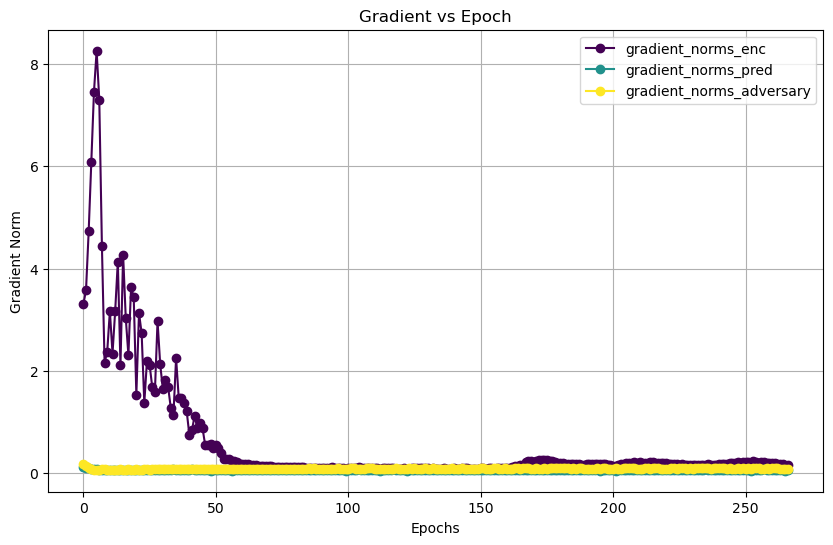

In [327]:
# plot_lines(range(len(epochs_total)), gradient_norms_enc, gradient_norms_pred, *gradient_norms_adversaries, labels=['gradient_norms_enc', 'gradient_norms_pred', 'gradient_norms_adversary'], title='Gradient vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')
plot_lines(range(len(epochs_total)), gradient_norms_enc, gradient_norms_pred, gradient_norms_adversaryA, labels=['gradient_norms_enc', 'gradient_norms_pred', 'gradient_norms_adversary'], title='Gradient vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

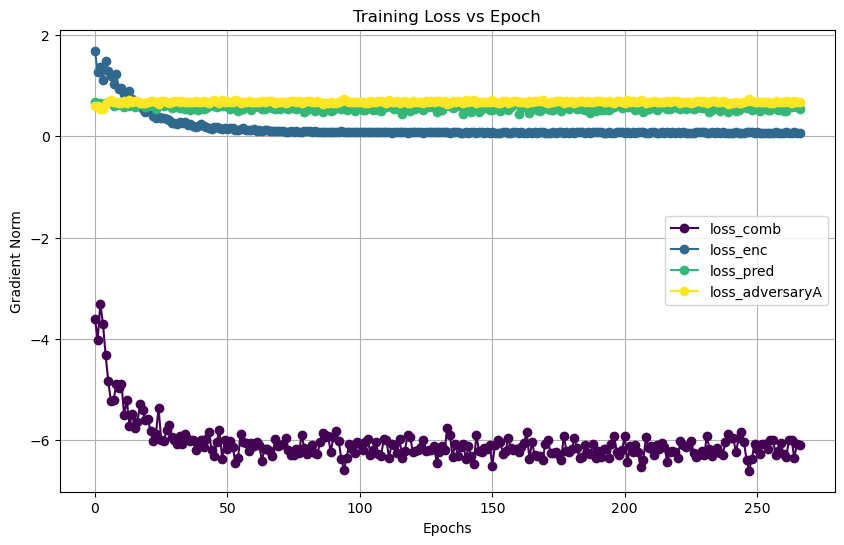

In [328]:
plot_lines(range(len(epochs_total)), loss_comb, loss_enc, loss_pred, loss_adversaryA, labels=['loss_comb', 'loss_enc', 'loss_pred', 'loss_adversaryA'], title='Training Loss vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

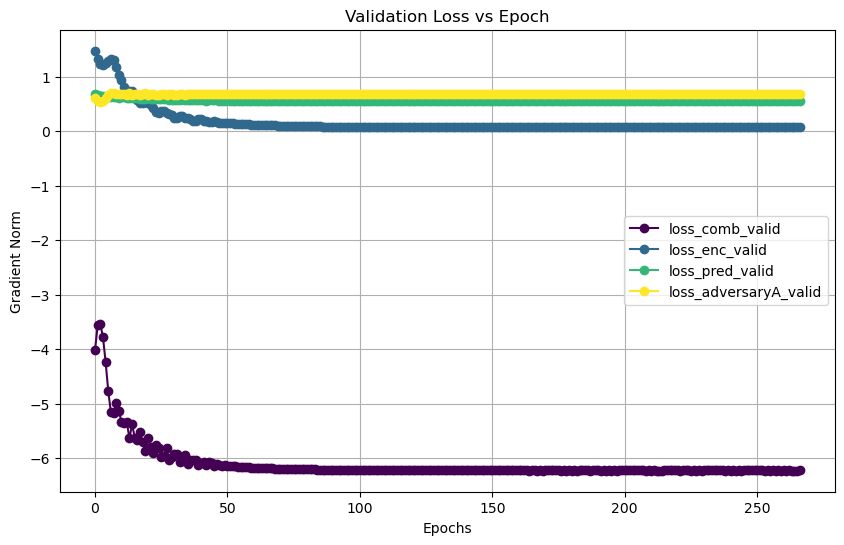

In [329]:
plot_lines(range(len(epochs_total)), loss_comb_valid, loss_enc_valid, loss_pred_valid, loss_adversaryA_valid, labels=['loss_comb_valid', 'loss_enc_valid', 'loss_pred_valid', 'loss_adversaryA_valid'], title='Validation Loss vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

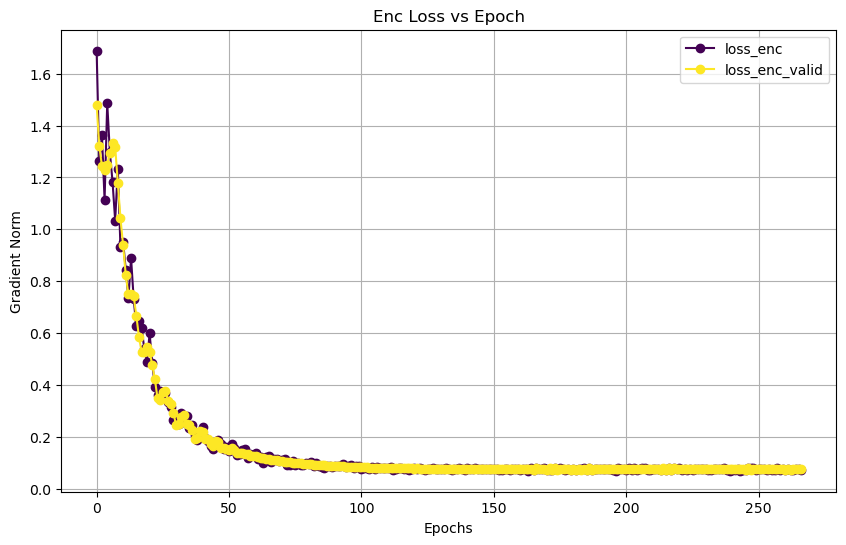

In [330]:
plot_lines(range(len(epochs_total)), loss_enc, loss_enc_valid, labels=['loss_enc', 'loss_enc_valid'], title='Enc Loss vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

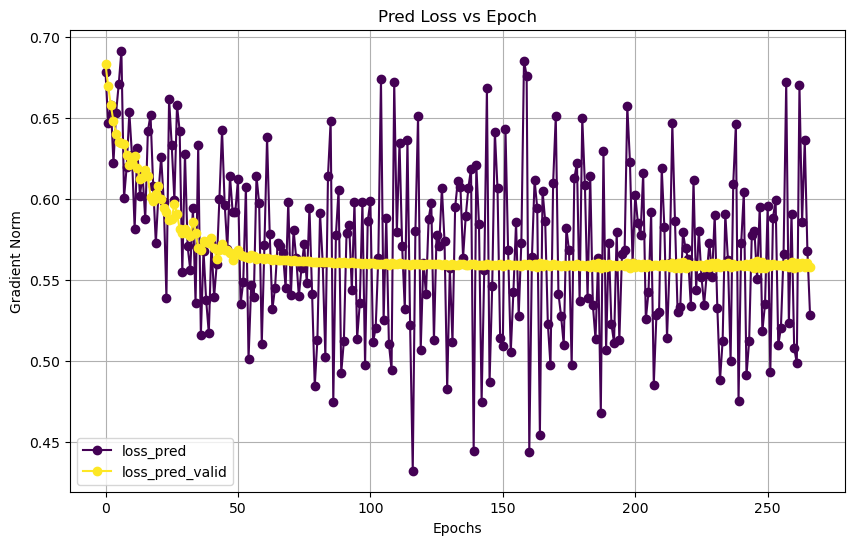

In [331]:
plot_lines(range(len(epochs_total)), loss_pred, loss_pred_valid, labels=['loss_pred', 'loss_pred_valid'], title='Pred Loss vs Epoch', xlabel='Epochs', ylabel='Gradient Norm')

In [332]:
new_df = get_transformed_features(test_loader, data_test, num_non_sensitive, num_sensitive, encoder)

In [333]:
new_df.head()

,X1,X2,X3,X4,S1,Y
0,-3.133697,-0.133129,0.432576,0.897392,1,1
1,-1.030692,1.170545,1.343877,-0.032151,0,1
2,-0.614749,2.272739,0.428048,-0.721458,1,0
3,-0.549857,1.914921,0.264533,0.577934,1,0
4,-1.045103,1.673020,0.334639,0.188016,0,1


In [334]:
data_test.head()

,X1,X2,X3,X4,S1,Y
6252,-3.066291,-0.365293,0.013936,0.761800,1,1
4684,-1.126902,1.492765,1.824010,0.076194,0,1
1731,-0.546208,2.046602,0.037479,-0.832383,1,0
4742,-0.486816,1.689986,-0.133291,0.455732,1,0
4521,-1.141271,1.999684,0.832077,0.305319,0,1


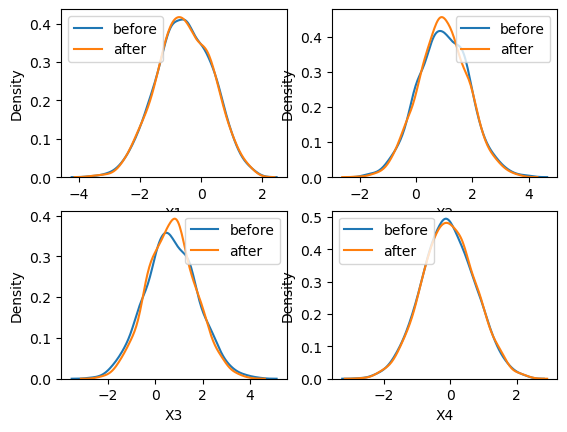

In [335]:
# _ = plt.figure()
# ax = plt.gca()

fig, ax = plt.subplots(2,2)
ax = ax.reshape(-1)

plt.subplot(2,2,1)
sns.kdeplot(data_test['X1'], ax=ax[0])
sns.kdeplot(new_df['X1'], ax=ax[0])
ax[0].legend(['before','after'])

plt.subplot(2,2,2)
sns.kdeplot(data_test['X2'], ax=ax[1])
sns.kdeplot(new_df['X2'], ax=ax[1])
ax[1].legend(['before','after'])

plt.subplot(2,2,3)
sns.kdeplot(data_test['X3'], ax=ax[2])
sns.kdeplot(new_df['X3'], ax=ax[2])
ax[2].legend(['before','after'])

plt.subplot(2,2,4)
sns.kdeplot(data_test['X4'], ax=ax[3])
sns.kdeplot(new_df['X4'], ax=ax[3])
ax[3].legend(['before','after'])

plt.show()

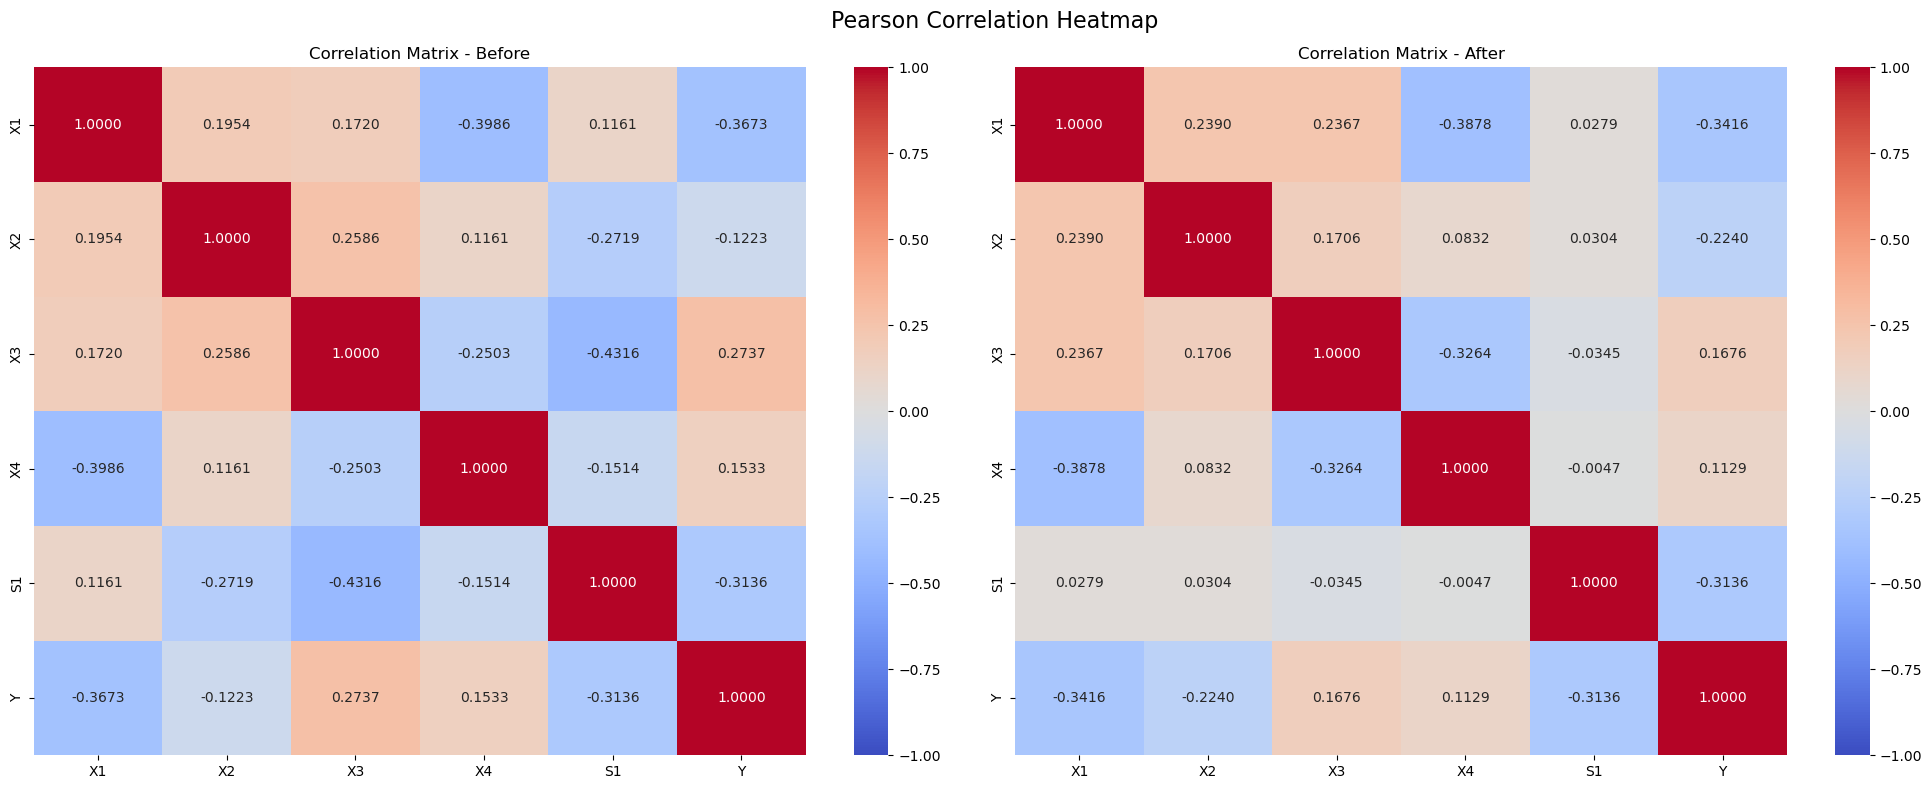

In [336]:
plot_comparison_heatmaps(data_test, new_df, figsize=(20, 8), cmap='coolwarm', vmin=-1, vmax=1)

In [337]:
y_true, y_logits, y_pred = get_predictions(data_test, num_non_sensitive, num_sensitive, encoder, predictor, threshold=0.5)

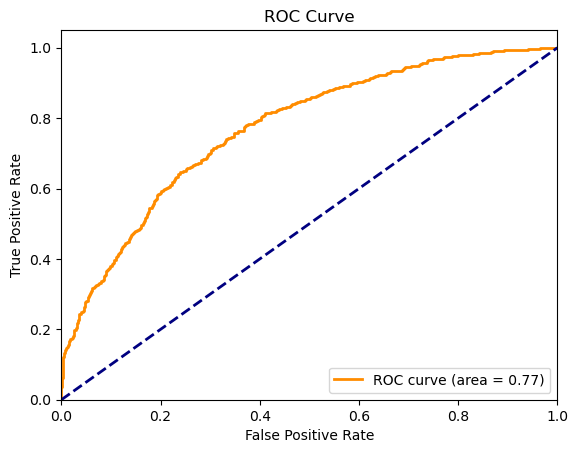

In [338]:
plot_auc_roc_curve(y_true, y_logits, title='ROC Curve')

In [339]:
np.unique(y_true, return_counts=True)

(array([0, 1]), array([751, 749]))

In [340]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([741, 759]))

In [341]:
metrics = evaluate_classifier(y_true, y_pred, y_logits)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.7027
Precision: 0.6996
Recall: 0.7089
F1 Score: 0.7042
ROC AUC Score: 0.7721


In [342]:
all_group_stats, all_demographic_parity = get_demographic_parity(y_true, y_pred, data_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 644                   345                  0.535714
1                 856                   414                  0.483645



Demographic parity for sensitive variable: S1
0.05206942590120156


In [343]:
new_df_train, new_df_test = perform_train_test_split(new_df, num_non_sensitive=num_non_sensitive, num_sensitive=num_sensitive, test_size=0.2,random_state=42)

print(new_df_train.shape, new_df_test.shape)

(1200, 6) (300, 6)


In [344]:
X_train, Y_train = new_df_train[['X1', 'X2', 'X3', 'X4']], new_df_train[['Y']]
X_test, Y_test = new_df_test[['X1', 'X2', 'X3', 'X4']], new_df_test[['Y']]
model_after = train_xgb_classifier(X_train, Y_train, seed=69)

Y_pred = model_after.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_after.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.7210460772104608


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:20:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [345]:
import optuna
from fairness.xgb_optuna import objective
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, Y_train, Y_test), n_trials=100)

[I 2024-12-04 17:20:31,805] A new study created in memory with name: no-name-7f18f6b7-d866-4d43-8c8a-dab0b0fdca1d
[I 2024-12-04 17:20:31,985] Trial 0 finished with value: 0.7270948229852339 and parameters: {'max_depth': 4, 'learning_rate': 0.03162191527633979, 'n_estimators': 325, 'subsample': 0.7986981920144114, 'colsample_bytree': 0.811437297435771, 'gamma': 0.050096329627368874, 'min_child_weight': 7}. Best is trial 0 with value: 0.7270948229852339.


Trial 0:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03162191527633979, 'n_estimators': 325, 'subsample': 0.7986981920144114, 'colsample_bytree': 0.811437297435771, 'gamma': 0.050096329627368874, 'min_child_weight': 7}
Accuracy: 0.6633333333333333, Precision: 0.6415094339622641, Recall: 0.6986301369863014, F1-score: 0.6688524590163935, AUC: 0.7270948229852339
--------------------------------------------------


[I 2024-12-04 17:20:32,219] Trial 1 finished with value: 0.6941380537270948 and parameters: {'max_depth': 4, 'learning_rate': 0.18281032636064223, 'n_estimators': 483, 'subsample': 0.809204930210609, 'colsample_bytree': 0.9938303993595092, 'gamma': 0.24729775307912538, 'min_child_weight': 5}. Best is trial 0 with value: 0.7270948229852339.
[I 2024-12-04 17:20:32,357] Trial 2 finished with value: 0.7239814979541007 and parameters: {'max_depth': 4, 'learning_rate': 0.036054131356012875, 'n_estimators': 273, 'subsample': 0.7633401078828089, 'colsample_bytree': 0.9884224707706926, 'gamma': 0.1798919631171716, 'min_child_weight': 5}. Best is trial 0 with value: 0.7270948229852339.


Trial 1:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.18281032636064223, 'n_estimators': 483, 'subsample': 0.809204930210609, 'colsample_bytree': 0.9938303993595092, 'gamma': 0.24729775307912538, 'min_child_weight': 5}
Accuracy: 0.6433333333333333, Precision: 0.6181818181818182, Recall: 0.6986301369863014, F1-score: 0.6559485530546624, AUC: 0.6941380537270948
--------------------------------------------------
Trial 2:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.036054131356012875, 'n_estimators': 273, 'subsample': 0.7633401078828089, 'colsample_bytree': 0.9884224707706926, 'gamma': 0.1798919631171716, 'min_child_weight': 5}
Accuracy: 0.68, Precision: 0.65625, Recall: 0.7191780821917808, F1-score: 0.6862745098039216, AUC: 0.7239814979541007
--------------------------------------------------


[I 2024-12-04 17:20:32,555] Trial 3 finished with value: 0.7109500088952143 and parameters: {'max_depth': 4, 'learning_rate': 0.10335054884975685, 'n_estimators': 484, 'subsample': 0.7470228502181765, 'colsample_bytree': 0.7961496643471454, 'gamma': 0.13970068165307004, 'min_child_weight': 8}. Best is trial 0 with value: 0.7270948229852339.
[I 2024-12-04 17:20:32,675] Trial 4 finished with value: 0.7248265433196939 and parameters: {'max_depth': 3, 'learning_rate': 0.036345434967415366, 'n_estimators': 239, 'subsample': 0.945441400933478, 'colsample_bytree': 0.9136794350935091, 'gamma': 0.32707561262688345, 'min_child_weight': 4}. Best is trial 0 with value: 0.7270948229852339.


Trial 3:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.10335054884975685, 'n_estimators': 484, 'subsample': 0.7470228502181765, 'colsample_bytree': 0.7961496643471454, 'gamma': 0.13970068165307004, 'min_child_weight': 8}
Accuracy: 0.66, Precision: 0.6375, Recall: 0.6986301369863014, F1-score: 0.6666666666666666, AUC: 0.7109500088952143
--------------------------------------------------
Trial 4:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.036345434967415366, 'n_estimators': 239, 'subsample': 0.945441400933478, 'colsample_bytree': 0.9136794350935091, 'gamma': 0.32707561262688345, 'min_child_weight': 4}
Accuracy: 0.68, Precision: 0.6602564102564102, Recall: 0.7054794520547946, F1-score: 0.6821192052980133, AUC: 0.7248265433196939
--------------------------------------------------


[I 2024-12-04 17:20:32,795] Trial 5 finished with value: 0.7290517701476606 and parameters: {'max_depth': 5, 'learning_rate': 0.013469476166466852, 'n_estimators': 153, 'subsample': 0.7243019889571752, 'colsample_bytree': 0.8487765727693284, 'gamma': 0.2466233912283305, 'min_child_weight': 2}. Best is trial 5 with value: 0.7290517701476606.
[I 2024-12-04 17:20:32,914] Trial 6 finished with value: 0.7038783134673545 and parameters: {'max_depth': 3, 'learning_rate': 0.16061677242071468, 'n_estimators': 267, 'subsample': 0.8030743328618541, 'colsample_bytree': 0.9107203537058323, 'gamma': 0.4910097895903711, 'min_child_weight': 4}. Best is trial 5 with value: 0.7290517701476606.


Trial 5:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.013469476166466852, 'n_estimators': 153, 'subsample': 0.7243019889571752, 'colsample_bytree': 0.8487765727693284, 'gamma': 0.2466233912283305, 'min_child_weight': 2}
Accuracy: 0.68, Precision: 0.6602564102564102, Recall: 0.7054794520547946, F1-score: 0.6821192052980133, AUC: 0.7290517701476606
--------------------------------------------------
Trial 6:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.16061677242071468, 'n_estimators': 267, 'subsample': 0.8030743328618541, 'colsample_bytree': 0.9107203537058323, 'gamma': 0.4910097895903711, 'min_child_weight': 4}
Accuracy: 0.6166666666666667, Precision: 0.5974842767295597, Recall: 0.6506849315068494, F1-score: 0.6229508196721312, AUC: 0.7038783134673545
--------------------------------------------------


[I 2024-12-04 17:20:33,003] Trial 7 finished with value: 0.7267390144102474 and parameters: {'max_depth': 6, 'learning_rate': 0.023479170664175708, 'n_estimators': 131, 'subsample': 0.7960994971690105, 'colsample_bytree': 0.7335252319902515, 'gamma': 0.14137951032386586, 'min_child_weight': 6}. Best is trial 5 with value: 0.7290517701476606.
[I 2024-12-04 17:20:33,182] Trial 8 finished with value: 0.7244707347447074 and parameters: {'max_depth': 4, 'learning_rate': 0.03158818194451704, 'n_estimators': 429, 'subsample': 0.7637373625908628, 'colsample_bytree': 0.8258996132401331, 'gamma': 0.485531859857299, 'min_child_weight': 8}. Best is trial 5 with value: 0.7290517701476606.


Trial 7:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.023479170664175708, 'n_estimators': 131, 'subsample': 0.7960994971690105, 'colsample_bytree': 0.7335252319902515, 'gamma': 0.14137951032386586, 'min_child_weight': 6}
Accuracy: 0.6766666666666666, Precision: 0.6560509554140127, Recall: 0.7054794520547946, F1-score: 0.6798679867986799, AUC: 0.7267390144102474
--------------------------------------------------
Trial 8:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.03158818194451704, 'n_estimators': 429, 'subsample': 0.7637373625908628, 'colsample_bytree': 0.8258996132401331, 'gamma': 0.485531859857299, 'min_child_weight': 8}
Accuracy: 0.67, Precision: 0.6441717791411042, Recall: 0.7191780821917808, F1-score: 0.6796116504854369, AUC: 0.7244707347447074
--------------------------------------------------


[I 2024-12-04 17:20:33,309] Trial 9 finished with value: 0.7137075253513611 and parameters: {'max_depth': 5, 'learning_rate': 0.21590792338800213, 'n_estimators': 196, 'subsample': 0.8883239796913567, 'colsample_bytree': 0.8630791306189327, 'gamma': 0.4565669045261705, 'min_child_weight': 3}. Best is trial 5 with value: 0.7290517701476606.


Trial 9:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.21590792338800213, 'n_estimators': 196, 'subsample': 0.8883239796913567, 'colsample_bytree': 0.8630791306189327, 'gamma': 0.4565669045261705, 'min_child_weight': 3}
Accuracy: 0.66, Precision: 0.6375, Recall: 0.6986301369863014, F1-score: 0.6666666666666666, AUC: 0.7137075253513611
--------------------------------------------------


[I 2024-12-04 17:20:33,579] Trial 10 finished with value: 0.7269613947696139 and parameters: {'max_depth': 6, 'learning_rate': 0.011088757195616429, 'n_estimators': 151, 'subsample': 0.7004658005298897, 'colsample_bytree': 0.701478180263714, 'gamma': 0.3477745594555172, 'min_child_weight': 1}. Best is trial 5 with value: 0.7290517701476606.


Trial 10:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.011088757195616429, 'n_estimators': 151, 'subsample': 0.7004658005298897, 'colsample_bytree': 0.701478180263714, 'gamma': 0.3477745594555172, 'min_child_weight': 1}
Accuracy: 0.6866666666666666, Precision: 0.6604938271604939, Recall: 0.7328767123287672, F1-score: 0.6948051948051948, AUC: 0.7269613947696139
--------------------------------------------------


[I 2024-12-04 17:20:33,843] Trial 11 finished with value: 0.7274506315602206 and parameters: {'max_depth': 5, 'learning_rate': 0.012344723733378807, 'n_estimators': 345, 'subsample': 0.8677612640710846, 'colsample_bytree': 0.7785725256591312, 'gamma': 0.04516899197825949, 'min_child_weight': 10}. Best is trial 5 with value: 0.7290517701476606.


Trial 11:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.012344723733378807, 'n_estimators': 345, 'subsample': 0.8677612640710846, 'colsample_bytree': 0.7785725256591312, 'gamma': 0.04516899197825949, 'min_child_weight': 10}
Accuracy: 0.6833333333333333, Precision: 0.6583850931677019, Recall: 0.726027397260274, F1-score: 0.6905537459283387, AUC: 0.7274506315602206
--------------------------------------------------


[I 2024-12-04 17:20:34,117] Trial 12 finished with value: 0.7277619640633339 and parameters: {'max_depth': 5, 'learning_rate': 0.010058923993031228, 'n_estimators': 355, 'subsample': 0.871573667051164, 'colsample_bytree': 0.7744364808931591, 'gamma': 0.010382392614075198, 'min_child_weight': 1}. Best is trial 5 with value: 0.7290517701476606.


Trial 12:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.010058923993031228, 'n_estimators': 355, 'subsample': 0.871573667051164, 'colsample_bytree': 0.7744364808931591, 'gamma': 0.010382392614075198, 'min_child_weight': 1}
Accuracy: 0.6866666666666666, Precision: 0.6645569620253164, Recall: 0.7191780821917808, F1-score: 0.6907894736842105, AUC: 0.7277619640633339
--------------------------------------------------


[I 2024-12-04 17:20:34,379] Trial 13 finished with value: 0.7268724426258673 and parameters: {'max_depth': 5, 'learning_rate': 0.014794087025461903, 'n_estimators': 386, 'subsample': 0.9317512827617463, 'colsample_bytree': 0.8708306441234055, 'gamma': 0.0010901198498493025, 'min_child_weight': 1}. Best is trial 5 with value: 0.7290517701476606.
[I 2024-12-04 17:20:34,503] Trial 14 finished with value: 0.7301636719444938 and parameters: {'max_depth': 6, 'learning_rate': 0.06691079747748262, 'n_estimators': 105, 'subsample': 0.9937757228654125, 'colsample_bytree': 0.7595334349244913, 'gamma': 0.27497376620925096, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 13:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.014794087025461903, 'n_estimators': 386, 'subsample': 0.9317512827617463, 'colsample_bytree': 0.8708306441234055, 'gamma': 0.0010901198498493025, 'min_child_weight': 1}
Accuracy: 0.6866666666666666, Precision: 0.6645569620253164, Recall: 0.7191780821917808, F1-score: 0.6907894736842105, AUC: 0.7268724426258673
--------------------------------------------------
Trial 14:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06691079747748262, 'n_estimators': 105, 'subsample': 0.9937757228654125, 'colsample_bytree': 0.7595334349244913, 'gamma': 0.27497376620925096, 'min_child_weight': 2}
Accuracy: 0.6833333333333333, Precision: 0.6645161290322581, Recall: 0.7054794520547946, F1-score: 0.6843853820598007, AUC: 0.7301636719444938
--------------------------------------------------


[I 2024-12-04 17:20:34,640] Trial 15 finished with value: 0.7254492083259206 and parameters: {'max_depth': 6, 'learning_rate': 0.0710955454490594, 'n_estimators': 101, 'subsample': 0.9957217040347204, 'colsample_bytree': 0.7459183931589725, 'gamma': 0.3163760816859782, 'min_child_weight': 3}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:34,788] Trial 16 finished with value: 0.728162248710194 and parameters: {'max_depth': 6, 'learning_rate': 0.06802555600784911, 'n_estimators': 176, 'subsample': 0.9946993203761894, 'colsample_bytree': 0.9082941458275201, 'gamma': 0.2417218692703911, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 15:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0710955454490594, 'n_estimators': 101, 'subsample': 0.9957217040347204, 'colsample_bytree': 0.7459183931589725, 'gamma': 0.3163760816859782, 'min_child_weight': 3}
Accuracy: 0.67, Precision: 0.6577181208053692, Recall: 0.6712328767123288, F1-score: 0.6644067796610169, AUC: 0.7254492083259206
--------------------------------------------------
Trial 16:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06802555600784911, 'n_estimators': 176, 'subsample': 0.9946993203761894, 'colsample_bytree': 0.9082941458275201, 'gamma': 0.2417218692703911, 'min_child_weight': 2}
Accuracy: 0.69, Precision: 0.6687898089171974, Recall: 0.7191780821917808, F1-score: 0.693069306930693, AUC: 0.728162248710194
--------------------------------------------------


[I 2024-12-04 17:20:34,962] Trial 17 finished with value: 0.710371819960861 and parameters: {'max_depth': 6, 'learning_rate': 0.1125210310748445, 'n_estimators': 208, 'subsample': 0.7048517536452505, 'colsample_bytree': 0.8439161967607619, 'gamma': 0.4039530329420998, 'min_child_weight': 3}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:35,094] Trial 18 finished with value: 0.7255381604696673 and parameters: {'max_depth': 5, 'learning_rate': 0.018612715284420867, 'n_estimators': 103, 'subsample': 0.9158442116110581, 'colsample_bytree': 0.7014379235283873, 'gamma': 0.19974874608441662, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 17:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1125210310748445, 'n_estimators': 208, 'subsample': 0.7048517536452505, 'colsample_bytree': 0.8439161967607619, 'gamma': 0.4039530329420998, 'min_child_weight': 3}
Accuracy: 0.67, Precision: 0.6459627329192547, Recall: 0.7123287671232876, F1-score: 0.6775244299674267, AUC: 0.710371819960861
--------------------------------------------------
Trial 18:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.018612715284420867, 'n_estimators': 103, 'subsample': 0.9158442116110581, 'colsample_bytree': 0.7014379235283873, 'gamma': 0.19974874608441662, 'min_child_weight': 2}
Accuracy: 0.6766666666666666, Precision: 0.6540880503144654, Recall: 0.7123287671232876, F1-score: 0.6819672131147541, AUC: 0.7255381604696673
--------------------------------------------------


[I 2024-12-04 17:20:35,302] Trial 19 finished with value: 0.7219355986479274 and parameters: {'max_depth': 6, 'learning_rate': 0.05454489831565301, 'n_estimators': 155, 'subsample': 0.8329627791485213, 'colsample_bytree': 0.7522513977530464, 'gamma': 0.2980503218856666, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:35,460] Trial 20 finished with value: 0.7153976160825476 and parameters: {'max_depth': 5, 'learning_rate': 0.053744025633625174, 'n_estimators': 228, 'subsample': 0.9600377587613896, 'colsample_bytree': 0.8855558221933468, 'gamma': 0.4060526475875713, 'min_child_weight': 4}. Best is trial 14 with value: 0.7301636719444938.


Trial 19:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05454489831565301, 'n_estimators': 155, 'subsample': 0.8329627791485213, 'colsample_bytree': 0.7522513977530464, 'gamma': 0.2980503218856666, 'min_child_weight': 2}
Accuracy: 0.6633333333333333, Precision: 0.6380368098159509, Recall: 0.7123287671232876, F1-score: 0.6731391585760518, AUC: 0.7219355986479274
--------------------------------------------------
Trial 20:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.053744025633625174, 'n_estimators': 228, 'subsample': 0.9600377587613896, 'colsample_bytree': 0.8855558221933468, 'gamma': 0.4060526475875713, 'min_child_weight': 4}
Accuracy: 0.6633333333333333, Precision: 0.643312101910828, Recall: 0.6917808219178082, F1-score: 0.6666666666666666, AUC: 0.7153976160825476
--------------------------------------------------


[I 2024-12-04 17:20:35,597] Trial 21 finished with value: 0.7246486390322006 and parameters: {'max_depth': 6, 'learning_rate': 0.0778205078331733, 'n_estimators': 180, 'subsample': 0.9878299283904942, 'colsample_bytree': 0.9511111951002875, 'gamma': 0.26156942192582433, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:35,711] Trial 22 finished with value: 0.7056573563422879 and parameters: {'max_depth': 6, 'learning_rate': 0.29627703847327636, 'n_estimators': 170, 'subsample': 0.9696413918255788, 'colsample_bytree': 0.9195712889113831, 'gamma': 0.24082205080497185, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 21:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0778205078331733, 'n_estimators': 180, 'subsample': 0.9878299283904942, 'colsample_bytree': 0.9511111951002875, 'gamma': 0.26156942192582433, 'min_child_weight': 2}
Accuracy: 0.68, Precision: 0.6602564102564102, Recall: 0.7054794520547946, F1-score: 0.6821192052980133, AUC: 0.7246486390322006
--------------------------------------------------
Trial 22:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.29627703847327636, 'n_estimators': 170, 'subsample': 0.9696413918255788, 'colsample_bytree': 0.9195712889113831, 'gamma': 0.24082205080497185, 'min_child_weight': 2}
Accuracy: 0.6366666666666667, Precision: 0.6134969325153374, Recall: 0.684931506849315, F1-score: 0.6472491909385113, AUC: 0.7056573563422879
--------------------------------------------------


[I 2024-12-04 17:20:35,852] Trial 23 finished with value: 0.7211795054260808 and parameters: {'max_depth': 6, 'learning_rate': 0.07076811951384818, 'n_estimators': 124, 'subsample': 0.9127923932767894, 'colsample_bytree': 0.9467056250789686, 'gamma': 0.2055770481323089, 'min_child_weight': 3}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:35,988] Trial 24 finished with value: 0.7213574097135741 and parameters: {'max_depth': 5, 'learning_rate': 0.046185488080400836, 'n_estimators': 135, 'subsample': 0.9747495400621726, 'colsample_bytree': 0.8340503302194913, 'gamma': 0.14253639052833217, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.


Trial 23:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07076811951384818, 'n_estimators': 124, 'subsample': 0.9127923932767894, 'colsample_bytree': 0.9467056250789686, 'gamma': 0.2055770481323089, 'min_child_weight': 3}
Accuracy: 0.6666666666666666, Precision: 0.6455696202531646, Recall: 0.6986301369863014, F1-score: 0.6710526315789473, AUC: 0.7211795054260808
--------------------------------------------------
Trial 24:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.046185488080400836, 'n_estimators': 135, 'subsample': 0.9747495400621726, 'colsample_bytree': 0.8340503302194913, 'gamma': 0.14253639052833217, 'min_child_weight': 1}
Accuracy: 0.6666666666666666, Precision: 0.6474358974358975, Recall: 0.6917808219178082, F1-score: 0.6688741721854304, AUC: 0.7213574097135741
--------------------------------------------------


[I 2024-12-04 17:20:36,144] Trial 25 finished with value: 0.7174435153887209 and parameters: {'max_depth': 6, 'learning_rate': 0.1146967425469907, 'n_estimators': 217, 'subsample': 0.9971125483551483, 'colsample_bytree': 0.9003711351042089, 'gamma': 0.37046201316745775, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 25:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1146967425469907, 'n_estimators': 217, 'subsample': 0.9971125483551483, 'colsample_bytree': 0.9003711351042089, 'gamma': 0.37046201316745775, 'min_child_weight': 2}
Accuracy: 0.6766666666666666, Precision: 0.6560509554140127, Recall: 0.7054794520547946, F1-score: 0.6798679867986799, AUC: 0.7174435153887209
--------------------------------------------------


[I 2024-12-04 17:20:36,370] Trial 26 finished with value: 0.7243373065290875 and parameters: {'max_depth': 5, 'learning_rate': 0.024478421104975723, 'n_estimators': 260, 'subsample': 0.8369702647262905, 'colsample_bytree': 0.9333762350001795, 'gamma': 0.28638195764516805, 'min_child_weight': 3}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:36,520] Trial 27 finished with value: 0.7211350293542074 and parameters: {'max_depth': 6, 'learning_rate': 0.09129304773525207, 'n_estimators': 175, 'subsample': 0.9422551268920966, 'colsample_bytree': 0.9688488678846575, 'gamma': 0.2306158877614906, 'min_child_weight': 4}. Best is trial 14 with value: 0.7301636719444938.


Trial 26:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.024478421104975723, 'n_estimators': 260, 'subsample': 0.8369702647262905, 'colsample_bytree': 0.9333762350001795, 'gamma': 0.28638195764516805, 'min_child_weight': 3}
Accuracy: 0.6866666666666666, Precision: 0.6645569620253164, Recall: 0.7191780821917808, F1-score: 0.6907894736842105, AUC: 0.7243373065290875
--------------------------------------------------
Trial 27:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09129304773525207, 'n_estimators': 175, 'subsample': 0.9422551268920966, 'colsample_bytree': 0.9688488678846575, 'gamma': 0.2306158877614906, 'min_child_weight': 4}
Accuracy: 0.6666666666666666, Precision: 0.6402439024390244, Recall: 0.7191780821917808, F1-score: 0.6774193548387096, AUC: 0.7211350293542074
--------------------------------------------------


[I 2024-12-04 17:20:36,741] Trial 28 finished with value: 0.7092599181640278 and parameters: {'max_depth': 6, 'learning_rate': 0.14860323914376974, 'n_estimators': 290, 'subsample': 0.9025731349757699, 'colsample_bytree': 0.8804790514466296, 'gamma': 0.10729387515042849, 'min_child_weight': 6}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:36,844] Trial 29 finished with value: 0.7275395837039673 and parameters: {'max_depth': 5, 'learning_rate': 0.04313448090097751, 'n_estimators': 118, 'subsample': 0.7216869137296299, 'colsample_bytree': 0.8147454293748392, 'gamma': 0.2781547042860866, 'min_child_weight': 10}. Best is trial 14 with value: 0.7301636719444938.


Trial 28:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.14860323914376974, 'n_estimators': 290, 'subsample': 0.9025731349757699, 'colsample_bytree': 0.8804790514466296, 'gamma': 0.10729387515042849, 'min_child_weight': 6}
Accuracy: 0.66, Precision: 0.6375, Recall: 0.6986301369863014, F1-score: 0.6666666666666666, AUC: 0.7092599181640278
--------------------------------------------------
Trial 29:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.04313448090097751, 'n_estimators': 118, 'subsample': 0.7216869137296299, 'colsample_bytree': 0.8147454293748392, 'gamma': 0.2781547042860866, 'min_child_weight': 10}
Accuracy: 0.68, Precision: 0.6582278481012658, Recall: 0.7123287671232876, F1-score: 0.6842105263157895, AUC: 0.7275395837039673
--------------------------------------------------


[I 2024-12-04 17:20:36,975] Trial 30 finished with value: 0.7231809286603808 and parameters: {'max_depth': 3, 'learning_rate': 0.026667017212709334, 'n_estimators': 314, 'subsample': 0.959142628512985, 'colsample_bytree': 0.8518957017209952, 'gamma': 0.1738249524337384, 'min_child_weight': 7}. Best is trial 14 with value: 0.7301636719444938.


Trial 30:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.026667017212709334, 'n_estimators': 314, 'subsample': 0.959142628512985, 'colsample_bytree': 0.8518957017209952, 'gamma': 0.1738249524337384, 'min_child_weight': 7}
Accuracy: 0.67, Precision: 0.6496815286624203, Recall: 0.6986301369863014, F1-score: 0.6732673267326733, AUC: 0.7231809286603808
--------------------------------------------------


[I 2024-12-04 17:20:37,227] Trial 31 finished with value: 0.726561110122754 and parameters: {'max_depth': 5, 'learning_rate': 0.010103853489801466, 'n_estimators': 351, 'subsample': 0.8676298991879502, 'colsample_bytree': 0.7790307932181231, 'gamma': 0.0884324162020283, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.


Trial 31:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.010103853489801466, 'n_estimators': 351, 'subsample': 0.8676298991879502, 'colsample_bytree': 0.7790307932181231, 'gamma': 0.0884324162020283, 'min_child_weight': 1}
Accuracy: 0.68, Precision: 0.6602564102564102, Recall: 0.7054794520547946, F1-score: 0.6821192052980133, AUC: 0.726561110122754
--------------------------------------------------


[I 2024-12-04 17:20:37,472] Trial 32 finished with value: 0.7266055861946272 and parameters: {'max_depth': 5, 'learning_rate': 0.015352652508649868, 'n_estimators': 416, 'subsample': 0.7786438226321267, 'colsample_bytree': 0.7895332697394907, 'gamma': 0.011567909638538378, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.


Trial 32:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.015352652508649868, 'n_estimators': 416, 'subsample': 0.7786438226321267, 'colsample_bytree': 0.7895332697394907, 'gamma': 0.011567909638538378, 'min_child_weight': 1}
Accuracy: 0.6833333333333333, Precision: 0.6624203821656051, Recall: 0.7123287671232876, F1-score: 0.6864686468646864, AUC: 0.7266055861946272
--------------------------------------------------


[I 2024-12-04 17:20:37,738] Trial 33 finished with value: 0.7266500622665006 and parameters: {'max_depth': 4, 'learning_rate': 0.016032914022264002, 'n_estimators': 357, 'subsample': 0.7344490517829156, 'colsample_bytree': 0.7270642553865246, 'gamma': 0.21856052994686223, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 33:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.016032914022264002, 'n_estimators': 357, 'subsample': 0.7344490517829156, 'colsample_bytree': 0.7270642553865246, 'gamma': 0.21856052994686223, 'min_child_weight': 2}
Accuracy: 0.6866666666666666, Precision: 0.6666666666666666, Recall: 0.7123287671232876, F1-score: 0.6887417218543046, AUC: 0.7266500622665006
--------------------------------------------------


[I 2024-12-04 17:20:37,959] Trial 34 finished with value: 0.7272727272727272 and parameters: {'max_depth': 4, 'learning_rate': 0.02066969475574479, 'n_estimators': 456, 'subsample': 0.8702151613412294, 'colsample_bytree': 0.7734810667752777, 'gamma': 0.07992149277404659, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:38,095] Trial 35 finished with value: 0.7286070094289273 and parameters: {'max_depth': 5, 'learning_rate': 0.01323682698706422, 'n_estimators': 152, 'subsample': 0.8355256093469249, 'colsample_bytree': 0.8047900659277718, 'gamma': 0.26708680328688833, 'min_child_weight': 5}. Best is trial 14 with value: 0.7301636719444938.


Trial 34:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.02066969475574479, 'n_estimators': 456, 'subsample': 0.8702151613412294, 'colsample_bytree': 0.7734810667752777, 'gamma': 0.07992149277404659, 'min_child_weight': 1}
Accuracy: 0.67, Precision: 0.6516129032258065, Recall: 0.6917808219178082, F1-score: 0.6710963455149501, AUC: 0.7272727272727272
--------------------------------------------------
Trial 35:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01323682698706422, 'n_estimators': 152, 'subsample': 0.8355256093469249, 'colsample_bytree': 0.8047900659277718, 'gamma': 0.26708680328688833, 'min_child_weight': 5}
Accuracy: 0.6666666666666666, Precision: 0.6474358974358975, Recall: 0.6917808219178082, F1-score: 0.6688741721854304, AUC: 0.7286070094289273
--------------------------------------------------


[I 2024-12-04 17:20:38,230] Trial 36 finished with value: 0.7266500622665006 and parameters: {'max_depth': 6, 'learning_rate': 0.031915250717858286, 'n_estimators': 150, 'subsample': 0.8279994634951509, 'colsample_bytree': 0.804303061657796, 'gamma': 0.2594668203539743, 'min_child_weight': 5}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:38,348] Trial 37 finished with value: 0.7219800747198007 and parameters: {'max_depth': 4, 'learning_rate': 0.06259520901913201, 'n_estimators': 187, 'subsample': 0.7845474031811676, 'colsample_bytree': 0.8263365643085564, 'gamma': 0.17608161192634642, 'min_child_weight': 5}. Best is trial 14 with value: 0.7301636719444938.


Trial 36:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.031915250717858286, 'n_estimators': 150, 'subsample': 0.8279994634951509, 'colsample_bytree': 0.804303061657796, 'gamma': 0.2594668203539743, 'min_child_weight': 5}
Accuracy: 0.6733333333333333, Precision: 0.6518987341772152, Recall: 0.7054794520547946, F1-score: 0.6776315789473685, AUC: 0.7266500622665006
--------------------------------------------------
Trial 37:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.06259520901913201, 'n_estimators': 187, 'subsample': 0.7845474031811676, 'colsample_bytree': 0.8263365643085564, 'gamma': 0.17608161192634642, 'min_child_weight': 5}
Accuracy: 0.6666666666666666, Precision: 0.6419753086419753, Recall: 0.7123287671232876, F1-score: 0.6753246753246753, AUC: 0.7219800747198007
--------------------------------------------------


[I 2024-12-04 17:20:38,478] Trial 38 finished with value: 0.7243373065290873 and parameters: {'max_depth': 5, 'learning_rate': 0.03866680391984925, 'n_estimators': 157, 'subsample': 0.8111270943390811, 'colsample_bytree': 0.754976793822699, 'gamma': 0.34721762424686503, 'min_child_weight': 8}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:38,650] Trial 39 finished with value: 0.7264721579790073 and parameters: {'max_depth': 6, 'learning_rate': 0.012602120953339062, 'n_estimators': 245, 'subsample': 0.9332645149319692, 'colsample_bytree': 0.814968525621279, 'gamma': 0.32505766316586865, 'min_child_weight': 7}. Best is trial 14 with value: 0.7301636719444938.


Trial 38:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.03866680391984925, 'n_estimators': 157, 'subsample': 0.8111270943390811, 'colsample_bytree': 0.754976793822699, 'gamma': 0.34721762424686503, 'min_child_weight': 8}
Accuracy: 0.6833333333333333, Precision: 0.660377358490566, Recall: 0.7191780821917808, F1-score: 0.6885245901639344, AUC: 0.7243373065290873
--------------------------------------------------
Trial 39:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.012602120953339062, 'n_estimators': 245, 'subsample': 0.9332645149319692, 'colsample_bytree': 0.814968525621279, 'gamma': 0.32505766316586865, 'min_child_weight': 7}
Accuracy: 0.6733333333333333, Precision: 0.65, Recall: 0.7123287671232876, F1-score: 0.6797385620915033, AUC: 0.7264721579790073
--------------------------------------------------


[I 2024-12-04 17:20:38,765] Trial 40 finished with value: 0.7230475004447607 and parameters: {'max_depth': 3, 'learning_rate': 0.030037083076061524, 'n_estimators': 207, 'subsample': 0.9820877572562342, 'colsample_bytree': 0.8544668847785512, 'gamma': 0.29909014360693165, 'min_child_weight': 6}. Best is trial 14 with value: 0.7301636719444938.


Trial 40:
Hyperparameters: {'max_depth': 3, 'learning_rate': 0.030037083076061524, 'n_estimators': 207, 'subsample': 0.9820877572562342, 'colsample_bytree': 0.8544668847785512, 'gamma': 0.29909014360693165, 'min_child_weight': 6}
Accuracy: 0.6733333333333333, Precision: 0.6578947368421053, Recall: 0.684931506849315, F1-score: 0.6711409395973155, AUC: 0.7230475004447607
--------------------------------------------------


[I 2024-12-04 17:20:38,987] Trial 41 finished with value: 0.7277619640633339 and parameters: {'max_depth': 5, 'learning_rate': 0.01304387357918976, 'n_estimators': 385, 'subsample': 0.7507773951174329, 'colsample_bytree': 0.768742077048748, 'gamma': 0.2510756869037409, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:39,109] Trial 42 finished with value: 0.7253157801103006 and parameters: {'max_depth': 5, 'learning_rate': 0.018676399080099885, 'n_estimators': 126, 'subsample': 0.8468523362570104, 'colsample_bytree': 0.8017214170692529, 'gamma': 0.16546770430697225, 'min_child_weight': 3}. Best is trial 14 with value: 0.7301636719444938.


Trial 41:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.01304387357918976, 'n_estimators': 385, 'subsample': 0.7507773951174329, 'colsample_bytree': 0.768742077048748, 'gamma': 0.2510756869037409, 'min_child_weight': 2}
Accuracy: 0.6933333333333334, Precision: 0.6730769230769231, Recall: 0.7191780821917808, F1-score: 0.695364238410596, AUC: 0.7277619640633339
--------------------------------------------------
Trial 42:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.018676399080099885, 'n_estimators': 126, 'subsample': 0.8468523362570104, 'colsample_bytree': 0.8017214170692529, 'gamma': 0.16546770430697225, 'min_child_weight': 3}
Accuracy: 0.6733333333333333, Precision: 0.6538461538461539, Recall: 0.6986301369863014, F1-score: 0.6754966887417219, AUC: 0.7253157801103006
--------------------------------------------------


[I 2024-12-04 17:20:39,281] Trial 43 finished with value: 0.7202455079167407 and parameters: {'max_depth': 5, 'learning_rate': 0.011035112061919521, 'n_estimators': 287, 'subsample': 0.8205855532206486, 'colsample_bytree': 0.7269799002214927, 'gamma': 0.20605608671657838, 'min_child_weight': 4}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:39,392] Trial 44 finished with value: 0.7247153531400106 and parameters: {'max_depth': 4, 'learning_rate': 0.013721647533795935, 'n_estimators': 139, 'subsample': 0.8947378164492797, 'colsample_bytree': 0.7884369750716742, 'gamma': 0.27388907654539485, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.


Trial 43:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.011035112061919521, 'n_estimators': 287, 'subsample': 0.8205855532206486, 'colsample_bytree': 0.7269799002214927, 'gamma': 0.20605608671657838, 'min_child_weight': 4}
Accuracy: 0.6766666666666666, Precision: 0.6560509554140127, Recall: 0.7054794520547946, F1-score: 0.6798679867986799, AUC: 0.7202455079167407
--------------------------------------------------
Trial 44:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.013721647533795935, 'n_estimators': 139, 'subsample': 0.8947378164492797, 'colsample_bytree': 0.7884369750716742, 'gamma': 0.27388907654539485, 'min_child_weight': 1}
Accuracy: 0.6766666666666666, Precision: 0.6580645161290323, Recall: 0.6986301369863014, F1-score: 0.6777408637873754, AUC: 0.7247153531400106
--------------------------------------------------


[I 2024-12-04 17:20:39,556] Trial 45 finished with value: 0.7109944849670876 and parameters: {'max_depth': 5, 'learning_rate': 0.09725247301743761, 'n_estimators': 327, 'subsample': 0.878720064718074, 'colsample_bytree': 0.7631662764943804, 'gamma': 0.3994849029980804, 'min_child_weight': 9}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:39,678] Trial 46 finished with value: 0.7248265433196939 and parameters: {'max_depth': 6, 'learning_rate': 0.01677528646839439, 'n_estimators': 114, 'subsample': 0.8532259736879761, 'colsample_bytree': 0.7414844269354078, 'gamma': 0.352410009119661, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 45:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.09725247301743761, 'n_estimators': 327, 'subsample': 0.878720064718074, 'colsample_bytree': 0.7631662764943804, 'gamma': 0.3994849029980804, 'min_child_weight': 9}
Accuracy: 0.6666666666666666, Precision: 0.64375, Recall: 0.7054794520547946, F1-score: 0.673202614379085, AUC: 0.7109944849670876
--------------------------------------------------
Trial 46:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.01677528646839439, 'n_estimators': 114, 'subsample': 0.8532259736879761, 'colsample_bytree': 0.7414844269354078, 'gamma': 0.352410009119661, 'min_child_weight': 2}
Accuracy: 0.6833333333333333, Precision: 0.6624203821656051, Recall: 0.7123287671232876, F1-score: 0.6864686468646864, AUC: 0.7248265433196939
--------------------------------------------------


[I 2024-12-04 17:20:39,818] Trial 47 finished with value: 0.7249822095712507 and parameters: {'max_depth': 4, 'learning_rate': 0.011324999324131209, 'n_estimators': 160, 'subsample': 0.7622781858040358, 'colsample_bytree': 0.9959804529716333, 'gamma': 0.12354251043306771, 'min_child_weight': 3}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:39,968] Trial 48 finished with value: 0.7142857142857142 and parameters: {'max_depth': 5, 'learning_rate': 0.021619242840262273, 'n_estimators': 198, 'subsample': 0.950223455994942, 'colsample_bytree': 0.7151319568178941, 'gamma': 0.4550736298660126, 'min_child_weight': 4}. Best is trial 14 with value: 0.7301636719444938.


Trial 47:
Hyperparameters: {'max_depth': 4, 'learning_rate': 0.011324999324131209, 'n_estimators': 160, 'subsample': 0.7622781858040358, 'colsample_bytree': 0.9959804529716333, 'gamma': 0.12354251043306771, 'min_child_weight': 3}
Accuracy: 0.66, Precision: 0.6466666666666666, Recall: 0.6643835616438356, F1-score: 0.6554054054054054, AUC: 0.7249822095712507
--------------------------------------------------
Trial 48:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.021619242840262273, 'n_estimators': 198, 'subsample': 0.950223455994942, 'colsample_bytree': 0.7151319568178941, 'gamma': 0.4550736298660126, 'min_child_weight': 4}
Accuracy: 0.6833333333333333, Precision: 0.6583850931677019, Recall: 0.726027397260274, F1-score: 0.6905537459283387, AUC: 0.7142857142857142
--------------------------------------------------


[I 2024-12-04 17:20:40,112] Trial 49 finished with value: 0.7298968155132539 and parameters: {'max_depth': 6, 'learning_rate': 0.08708925997936294, 'n_estimators': 105, 'subsample': 0.9218661400419214, 'colsample_bytree': 0.8410810868861534, 'gamma': 0.05021765329018624, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:40,231] Trial 50 finished with value: 0.7171321828856075 and parameters: {'max_depth': 6, 'learning_rate': 0.12768462921554036, 'n_estimators': 106, 'subsample': 0.9298069510451171, 'colsample_bytree': 0.8697562356326065, 'gamma': 0.03629263015004813, 'min_child_weight': 5}. Best is trial 14 with value: 0.7301636719444938.


Trial 49:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08708925997936294, 'n_estimators': 105, 'subsample': 0.9218661400419214, 'colsample_bytree': 0.8410810868861534, 'gamma': 0.05021765329018624, 'min_child_weight': 1}
Accuracy: 0.6566666666666666, Precision: 0.6405228758169934, Recall: 0.6712328767123288, F1-score: 0.6555183946488294, AUC: 0.7298968155132539
--------------------------------------------------
Trial 50:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.12768462921554036, 'n_estimators': 106, 'subsample': 0.9298069510451171, 'colsample_bytree': 0.8697562356326065, 'gamma': 0.03629263015004813, 'min_child_weight': 5}
Accuracy: 0.6533333333333333, Precision: 0.6296296296296297, Recall: 0.6986301369863014, F1-score: 0.6623376623376623, AUC: 0.7171321828856075
--------------------------------------------------


[I 2024-12-04 17:20:40,422] Trial 51 finished with value: 0.7246931151040741 and parameters: {'max_depth': 6, 'learning_rate': 0.08018957139280343, 'n_estimators': 137, 'subsample': 0.9641441205629854, 'colsample_bytree': 0.840913880879952, 'gamma': 0.023307107083247316, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:40,611] Trial 52 finished with value: 0.7271392990571073 and parameters: {'max_depth': 6, 'learning_rate': 0.0641255376026614, 'n_estimators': 168, 'subsample': 0.9210550383498245, 'colsample_bytree': 0.8284925046530083, 'gamma': 0.07149324070888774, 'min_child_weight': 1}. Best is trial 14 with value: 0.7301636719444938.


Trial 51:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08018957139280343, 'n_estimators': 137, 'subsample': 0.9641441205629854, 'colsample_bytree': 0.840913880879952, 'gamma': 0.023307107083247316, 'min_child_weight': 1}
Accuracy: 0.6666666666666666, Precision: 0.6474358974358975, Recall: 0.6917808219178082, F1-score: 0.6688741721854304, AUC: 0.7246931151040741
--------------------------------------------------
Trial 52:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0641255376026614, 'n_estimators': 168, 'subsample': 0.9210550383498245, 'colsample_bytree': 0.8284925046530083, 'gamma': 0.07149324070888774, 'min_child_weight': 1}
Accuracy: 0.6766666666666666, Precision: 0.6521739130434783, Recall: 0.7191780821917808, F1-score: 0.6840390879478827, AUC: 0.7271392990571073
--------------------------------------------------


[I 2024-12-04 17:20:40,771] Trial 53 finished with value: 0.7263387297633872 and parameters: {'max_depth': 6, 'learning_rate': 0.04682126538308885, 'n_estimators': 140, 'subsample': 0.9796985551678539, 'colsample_bytree': 0.8878023477036646, 'gamma': 0.05372136766084018, 'min_child_weight': 2}. Best is trial 14 with value: 0.7301636719444938.


Trial 53:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04682126538308885, 'n_estimators': 140, 'subsample': 0.9796985551678539, 'colsample_bytree': 0.8878023477036646, 'gamma': 0.05372136766084018, 'min_child_weight': 2}
Accuracy: 0.6733333333333333, Precision: 0.65, Recall: 0.7123287671232876, F1-score: 0.6797385620915033, AUC: 0.7263387297633872
--------------------------------------------------


[I 2024-12-04 17:20:41,095] Trial 54 finished with value: 0.7167318982387476 and parameters: {'max_depth': 5, 'learning_rate': 0.06199039879158197, 'n_estimators': 374, 'subsample': 0.8537005669555368, 'colsample_bytree': 0.8585346326503572, 'gamma': 0.2993978885033975, 'min_child_weight': 3}. Best is trial 14 with value: 0.7301636719444938.
[I 2024-12-04 17:20:41,290] Trial 55 finished with value: 0.7353673723536738 and parameters: {'max_depth': 6, 'learning_rate': 0.0759892388214826, 'n_estimators': 105, 'subsample': 0.9889848497394246, 'colsample_bytree': 0.8184155131101626, 'gamma': 0.00031473692571033773, 'min_child_weight': 2}. Best is trial 55 with value: 0.7353673723536738.


Trial 54:
Hyperparameters: {'max_depth': 5, 'learning_rate': 0.06199039879158197, 'n_estimators': 374, 'subsample': 0.8537005669555368, 'colsample_bytree': 0.8585346326503572, 'gamma': 0.2993978885033975, 'min_child_weight': 3}
Accuracy: 0.6533333333333333, Precision: 0.63125, Recall: 0.6917808219178082, F1-score: 0.6601307189542484, AUC: 0.7167318982387476
--------------------------------------------------
Trial 55:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0759892388214826, 'n_estimators': 105, 'subsample': 0.9889848497394246, 'colsample_bytree': 0.8184155131101626, 'gamma': 0.00031473692571033773, 'min_child_weight': 2}
Accuracy: 0.69, Precision: 0.6687898089171974, Recall: 0.7191780821917808, F1-score: 0.693069306930693, AUC: 0.7353673723536738
--------------------------------------------------


[I 2024-12-04 17:20:41,478] Trial 56 finished with value: 0.7254492083259207 and parameters: {'max_depth': 6, 'learning_rate': 0.0869923957507343, 'n_estimators': 102, 'subsample': 0.9919437803307667, 'colsample_bytree': 0.8192159075969969, 'gamma': 0.23567994162889355, 'min_child_weight': 2}. Best is trial 55 with value: 0.7353673723536738.


Trial 56:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0869923957507343, 'n_estimators': 102, 'subsample': 0.9919437803307667, 'colsample_bytree': 0.8192159075969969, 'gamma': 0.23567994162889355, 'min_child_weight': 2}
Accuracy: 0.68, Precision: 0.6582278481012658, Recall: 0.7123287671232876, F1-score: 0.6842105263157895, AUC: 0.7254492083259207
--------------------------------------------------


[I 2024-12-04 17:20:41,688] Trial 57 finished with value: 0.7312310976694538 and parameters: {'max_depth': 6, 'learning_rate': 0.051116731099788724, 'n_estimators': 119, 'subsample': 0.9493180500256855, 'colsample_bytree': 0.8433858050677423, 'gamma': 0.0008067362635376068, 'min_child_weight': 2}. Best is trial 55 with value: 0.7353673723536738.
[I 2024-12-04 17:20:41,881] Trial 58 finished with value: 0.7129514321295145 and parameters: {'max_depth': 6, 'learning_rate': 0.1085124872248406, 'n_estimators': 119, 'subsample': 0.9410739775262348, 'colsample_bytree': 0.841025178966738, 'gamma': 0.05786219347360707, 'min_child_weight': 3}. Best is trial 55 with value: 0.7353673723536738.


Trial 57:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.051116731099788724, 'n_estimators': 119, 'subsample': 0.9493180500256855, 'colsample_bytree': 0.8433858050677423, 'gamma': 0.0008067362635376068, 'min_child_weight': 2}
Accuracy: 0.68, Precision: 0.6602564102564102, Recall: 0.7054794520547946, F1-score: 0.6821192052980133, AUC: 0.7312310976694538
--------------------------------------------------
Trial 58:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.1085124872248406, 'n_estimators': 119, 'subsample': 0.9410739775262348, 'colsample_bytree': 0.841025178966738, 'gamma': 0.05786219347360707, 'min_child_weight': 3}
Accuracy: 0.6666666666666666, Precision: 0.6455696202531646, Recall: 0.6986301369863014, F1-score: 0.6710526315789473, AUC: 0.7129514321295145
--------------------------------------------------


[I 2024-12-04 17:20:42,121] Trial 59 finished with value: 0.718555417185554 and parameters: {'max_depth': 6, 'learning_rate': 0.17101728124352403, 'n_estimators': 146, 'subsample': 0.949373459736356, 'colsample_bytree': 0.8663683029536832, 'gamma': 0.0006859064773553944, 'min_child_weight': 2}. Best is trial 55 with value: 0.7353673723536738.
[I 2024-12-04 17:20:42,307] Trial 60 finished with value: 0.7138854296388544 and parameters: {'max_depth': 6, 'learning_rate': 0.2245838389618809, 'n_estimators': 101, 'subsample': 0.9756141743902925, 'colsample_bytree': 0.8028347786591504, 'gamma': 0.017206509419571265, 'min_child_weight': 1}. Best is trial 55 with value: 0.7353673723536738.


Trial 59:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.17101728124352403, 'n_estimators': 146, 'subsample': 0.949373459736356, 'colsample_bytree': 0.8663683029536832, 'gamma': 0.0006859064773553944, 'min_child_weight': 2}
Accuracy: 0.66, Precision: 0.6392405063291139, Recall: 0.6917808219178082, F1-score: 0.6644736842105263, AUC: 0.718555417185554
--------------------------------------------------
Trial 60:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.2245838389618809, 'n_estimators': 101, 'subsample': 0.9756141743902925, 'colsample_bytree': 0.8028347786591504, 'gamma': 0.017206509419571265, 'min_child_weight': 1}
Accuracy: 0.66, Precision: 0.6410256410256411, Recall: 0.684931506849315, F1-score: 0.6622516556291391, AUC: 0.7138854296388544
--------------------------------------------------


[I 2024-12-04 17:20:42,521] Trial 61 finished with value: 0.7279398683508272 and parameters: {'max_depth': 6, 'learning_rate': 0.07256128878628522, 'n_estimators': 126, 'subsample': 0.9999484581139271, 'colsample_bytree': 0.834708101428234, 'gamma': 0.029911109793988644, 'min_child_weight': 2}. Best is trial 55 with value: 0.7353673723536738.


Trial 61:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07256128878628522, 'n_estimators': 126, 'subsample': 0.9999484581139271, 'colsample_bytree': 0.834708101428234, 'gamma': 0.029911109793988644, 'min_child_weight': 2}
Accuracy: 0.6766666666666666, Precision: 0.6601307189542484, Recall: 0.6917808219178082, F1-score: 0.6755852842809364, AUC: 0.7279398683508272
--------------------------------------------------


[I 2024-12-04 17:20:42,748] Trial 62 finished with value: 0.7235367372353674 and parameters: {'max_depth': 6, 'learning_rate': 0.13044185871320235, 'n_estimators': 115, 'subsample': 0.9841297818388042, 'colsample_bytree': 0.878812156037061, 'gamma': 0.034626583282405234, 'min_child_weight': 2}. Best is trial 55 with value: 0.7353673723536738.


Trial 62:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.13044185871320235, 'n_estimators': 115, 'subsample': 0.9841297818388042, 'colsample_bytree': 0.878812156037061, 'gamma': 0.034626583282405234, 'min_child_weight': 2}
Accuracy: 0.6666666666666666, Precision: 0.6455696202531646, Recall: 0.6986301369863014, F1-score: 0.6710526315789473, AUC: 0.7235367372353674
--------------------------------------------------
Trial 63:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.054285849122215554, 'n_estimators': 185, 'subsample': 0.9678920440146888, 'colsample_bytree': 0.8454873741573093, 'gamma': 0.1905511998233285, 'min_child_weight': 3}
Accuracy: 0.6666666666666666, Precision: 0.64375, Recall: 0.7054794520547946, F1-score: 0.673202614379085, AUC: 0.7235367372353674
--------------------------------------------------


[I 2024-12-04 17:20:42,948] Trial 63 finished with value: 0.7235367372353674 and parameters: {'max_depth': 6, 'learning_rate': 0.054285849122215554, 'n_estimators': 185, 'subsample': 0.9678920440146888, 'colsample_bytree': 0.8454873741573093, 'gamma': 0.1905511998233285, 'min_child_weight': 3}. Best is trial 55 with value: 0.7353673723536738.
[I 2024-12-04 17:20:43,135] Trial 64 finished with value: 0.7235812133072408 and parameters: {'max_depth': 6, 'learning_rate': 0.08297276871733472, 'n_estimators': 161, 'subsample': 0.9556415384935205, 'colsample_bytree': 0.8938183322349378, 'gamma': 0.22213573198241934, 'min_child_weight': 4}. Best is trial 55 with value: 0.7353673723536738.
[I 2024-12-04 17:20:43,277] Trial 65 finished with value: 0.7263387297633872 and parameters: {'max_depth': 6, 'learning_rate': 0.05048988674941592, 'n_estimators': 131, 'subsample': 0.9891547955721617, 'colsample_bytree': 0.790617607368202, 'gamma': 0.26008570438645207, 'min_child_weight': 1}. Best is trial 5

Trial 64:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.08297276871733472, 'n_estimators': 161, 'subsample': 0.9556415384935205, 'colsample_bytree': 0.8938183322349378, 'gamma': 0.22213573198241934, 'min_child_weight': 4}
Accuracy: 0.66, Precision: 0.6375, Recall: 0.6986301369863014, F1-score: 0.6666666666666666, AUC: 0.7235812133072408
--------------------------------------------------
Trial 65:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05048988674941592, 'n_estimators': 131, 'subsample': 0.9891547955721617, 'colsample_bytree': 0.790617607368202, 'gamma': 0.26008570438645207, 'min_child_weight': 1}
Accuracy: 0.6766666666666666, Precision: 0.6540880503144654, Recall: 0.7123287671232876, F1-score: 0.6819672131147541, AUC: 0.7263387297633872
--------------------------------------------------


[I 2024-12-04 17:20:43,427] Trial 66 finished with value: 0.7195338907667674 and parameters: {'max_depth': 6, 'learning_rate': 0.09576648149946816, 'n_estimators': 148, 'subsample': 0.9711516542527393, 'colsample_bytree': 0.8093205777139991, 'gamma': 0.15032308610707673, 'min_child_weight': 3}. Best is trial 55 with value: 0.7353673723536738.
[I 2024-12-04 17:20:43,555] Trial 67 finished with value: 0.7361234655755203 and parameters: {'max_depth': 6, 'learning_rate': 0.06628031898164718, 'n_estimators': 113, 'subsample': 0.9144222817184061, 'colsample_bytree': 0.9048576768411383, 'gamma': 0.10014217157678829, 'min_child_weight': 2}. Best is trial 67 with value: 0.7361234655755203.


Trial 66:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.09576648149946816, 'n_estimators': 148, 'subsample': 0.9711516542527393, 'colsample_bytree': 0.8093205777139991, 'gamma': 0.15032308610707673, 'min_child_weight': 3}
Accuracy: 0.67, Precision: 0.6516129032258065, Recall: 0.6917808219178082, F1-score: 0.6710963455149501, AUC: 0.7195338907667674
--------------------------------------------------
Trial 67:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06628031898164718, 'n_estimators': 113, 'subsample': 0.9144222817184061, 'colsample_bytree': 0.9048576768411383, 'gamma': 0.10014217157678829, 'min_child_weight': 2}
Accuracy: 0.6766666666666666, Precision: 0.6580645161290323, Recall: 0.6986301369863014, F1-score: 0.6777408637873754, AUC: 0.7361234655755203
--------------------------------------------------


[I 2024-12-04 17:20:43,692] Trial 68 finished with value: 0.7234922611634941 and parameters: {'max_depth': 6, 'learning_rate': 0.07389614274178696, 'n_estimators': 114, 'subsample': 0.8995440191609274, 'colsample_bytree': 0.8608754070834369, 'gamma': 0.09682808455067413, 'min_child_weight': 1}. Best is trial 67 with value: 0.7361234655755203.
[I 2024-12-04 17:20:43,831] Trial 69 finished with value: 0.7284291051414339 and parameters: {'max_depth': 6, 'learning_rate': 0.03897721775887648, 'n_estimators': 129, 'subsample': 0.9104182253231551, 'colsample_bytree': 0.921193869256433, 'gamma': 0.05060238205191851, 'min_child_weight': 2}. Best is trial 67 with value: 0.7361234655755203.


Trial 68:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07389614274178696, 'n_estimators': 114, 'subsample': 0.8995440191609274, 'colsample_bytree': 0.8608754070834369, 'gamma': 0.09682808455067413, 'min_child_weight': 1}
Accuracy: 0.6733333333333333, Precision: 0.6558441558441559, Recall: 0.6917808219178082, F1-score: 0.6733333333333333, AUC: 0.7234922611634941
--------------------------------------------------
Trial 69:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.03897721775887648, 'n_estimators': 129, 'subsample': 0.9104182253231551, 'colsample_bytree': 0.921193869256433, 'gamma': 0.05060238205191851, 'min_child_weight': 2}
Accuracy: 0.6833333333333333, Precision: 0.6645161290322581, Recall: 0.7054794520547946, F1-score: 0.6843853820598007, AUC: 0.7284291051414339
--------------------------------------------------


[I 2024-12-04 17:20:43,965] Trial 70 finished with value: 0.7235812133072406 and parameters: {'max_depth': 6, 'learning_rate': 0.058708510154685756, 'n_estimators': 109, 'subsample': 0.8852242384720638, 'colsample_bytree': 0.8222653495138641, 'gamma': 0.0020537780397245535, 'min_child_weight': 4}. Best is trial 67 with value: 0.7361234655755203.
[I 2024-12-04 17:20:44,101] Trial 71 finished with value: 0.7296299590820138 and parameters: {'max_depth': 6, 'learning_rate': 0.04072828094046968, 'n_estimators': 124, 'subsample': 0.9066549647853919, 'colsample_bytree': 0.9317379169901776, 'gamma': 0.052954218810925935, 'min_child_weight': 2}. Best is trial 67 with value: 0.7361234655755203.


Trial 70:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.058708510154685756, 'n_estimators': 109, 'subsample': 0.8852242384720638, 'colsample_bytree': 0.8222653495138641, 'gamma': 0.0020537780397245535, 'min_child_weight': 4}
Accuracy: 0.6733333333333333, Precision: 0.6518987341772152, Recall: 0.7054794520547946, F1-score: 0.6776315789473685, AUC: 0.7235812133072406
--------------------------------------------------
Trial 71:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04072828094046968, 'n_estimators': 124, 'subsample': 0.9066549647853919, 'colsample_bytree': 0.9317379169901776, 'gamma': 0.052954218810925935, 'min_child_weight': 2}
Accuracy: 0.68, Precision: 0.6602564102564102, Recall: 0.7054794520547946, F1-score: 0.6821192052980133, AUC: 0.7296299590820138
--------------------------------------------------


[I 2024-12-04 17:20:44,401] Trial 72 finished with value: 0.7216687422166874 and parameters: {'max_depth': 6, 'learning_rate': 0.044274745714239463, 'n_estimators': 499, 'subsample': 0.9286820931975495, 'colsample_bytree': 0.9738726816410572, 'gamma': 0.06216746314786213, 'min_child_weight': 2}. Best is trial 67 with value: 0.7361234655755203.
[I 2024-12-04 17:20:44,531] Trial 73 finished with value: 0.7294965308663939 and parameters: {'max_depth': 6, 'learning_rate': 0.06707484563921375, 'n_estimators': 101, 'subsample': 0.9209999921826522, 'colsample_bytree': 0.9307661309807655, 'gamma': 0.12302950959268602, 'min_child_weight': 3}. Best is trial 67 with value: 0.7361234655755203.


Trial 72:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.044274745714239463, 'n_estimators': 499, 'subsample': 0.9286820931975495, 'colsample_bytree': 0.9738726816410572, 'gamma': 0.06216746314786213, 'min_child_weight': 2}
Accuracy: 0.66, Precision: 0.6341463414634146, Recall: 0.7123287671232876, F1-score: 0.6709677419354839, AUC: 0.7216687422166874
--------------------------------------------------
Trial 73:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06707484563921375, 'n_estimators': 101, 'subsample': 0.9209999921826522, 'colsample_bytree': 0.9307661309807655, 'gamma': 0.12302950959268602, 'min_child_weight': 3}
Accuracy: 0.6733333333333333, Precision: 0.6518987341772152, Recall: 0.7054794520547946, F1-score: 0.6776315789473685, AUC: 0.7294965308663939
--------------------------------------------------


[I 2024-12-04 17:20:44,692] Trial 74 finished with value: 0.723759117594734 and parameters: {'max_depth': 6, 'learning_rate': 0.06698752188874103, 'n_estimators': 122, 'subsample': 0.9188836394305894, 'colsample_bytree': 0.9510869318643467, 'gamma': 0.11323059325094945, 'min_child_weight': 2}. Best is trial 67 with value: 0.7361234655755203.
[I 2024-12-04 17:20:44,824] Trial 75 finished with value: 0.7311866215975805 and parameters: {'max_depth': 6, 'learning_rate': 0.05717347290550173, 'n_estimators': 103, 'subsample': 0.9398737468240235, 'colsample_bytree': 0.9357355049645991, 'gamma': 0.07323040487134418, 'min_child_weight': 1}. Best is trial 67 with value: 0.7361234655755203.


Trial 74:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06698752188874103, 'n_estimators': 122, 'subsample': 0.9188836394305894, 'colsample_bytree': 0.9510869318643467, 'gamma': 0.11323059325094945, 'min_child_weight': 2}
Accuracy: 0.6566666666666666, Precision: 0.6369426751592356, Recall: 0.684931506849315, F1-score: 0.6600660066006601, AUC: 0.723759117594734
--------------------------------------------------
Trial 75:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05717347290550173, 'n_estimators': 103, 'subsample': 0.9398737468240235, 'colsample_bytree': 0.9357355049645991, 'gamma': 0.07323040487134418, 'min_child_weight': 1}
Accuracy: 0.6833333333333333, Precision: 0.660377358490566, Recall: 0.7191780821917808, F1-score: 0.6885245901639344, AUC: 0.7311866215975805
--------------------------------------------------


[I 2024-12-04 17:20:44,949] Trial 76 finished with value: 0.7372353673723537 and parameters: {'max_depth': 6, 'learning_rate': 0.056419789484223035, 'n_estimators': 103, 'subsample': 0.9398806626671339, 'colsample_bytree': 0.937135025195519, 'gamma': 0.08013082015297003, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:45,105] Trial 77 finished with value: 0.7305639565913539 and parameters: {'max_depth': 6, 'learning_rate': 0.057134669235153396, 'n_estimators': 113, 'subsample': 0.9399037064118949, 'colsample_bytree': 0.9408128266198804, 'gamma': 0.0807095172258788, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 76:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.056419789484223035, 'n_estimators': 103, 'subsample': 0.9398806626671339, 'colsample_bytree': 0.937135025195519, 'gamma': 0.08013082015297003, 'min_child_weight': 1}
Accuracy: 0.6866666666666666, Precision: 0.6604938271604939, Recall: 0.7328767123287672, F1-score: 0.6948051948051948, AUC: 0.7372353673723537
--------------------------------------------------
Trial 77:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.057134669235153396, 'n_estimators': 113, 'subsample': 0.9399037064118949, 'colsample_bytree': 0.9408128266198804, 'gamma': 0.0807095172258788, 'min_child_weight': 1}
Accuracy: 0.6766666666666666, Precision: 0.6521739130434783, Recall: 0.7191780821917808, F1-score: 0.6840390879478827, AUC: 0.7305639565913539
--------------------------------------------------


[I 2024-12-04 17:20:45,254] Trial 78 finished with value: 0.7305639565913539 and parameters: {'max_depth': 6, 'learning_rate': 0.049155650919694094, 'n_estimators': 113, 'subsample': 0.9427683720610881, 'colsample_bytree': 0.9626988963209557, 'gamma': 0.0799523334870784, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:45,416] Trial 79 finished with value: 0.730297100160114 and parameters: {'max_depth': 6, 'learning_rate': 0.0510699740374839, 'n_estimators': 139, 'subsample': 0.9416284622157026, 'colsample_bytree': 0.9437189797338724, 'gamma': 0.08556227603408559, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 78:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.049155650919694094, 'n_estimators': 113, 'subsample': 0.9427683720610881, 'colsample_bytree': 0.9626988963209557, 'gamma': 0.0799523334870784, 'min_child_weight': 1}
Accuracy: 0.6833333333333333, Precision: 0.6583850931677019, Recall: 0.726027397260274, F1-score: 0.6905537459283387, AUC: 0.7305639565913539
--------------------------------------------------
Trial 79:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0510699740374839, 'n_estimators': 139, 'subsample': 0.9416284622157026, 'colsample_bytree': 0.9437189797338724, 'gamma': 0.08556227603408559, 'min_child_weight': 1}
Accuracy: 0.6933333333333334, Precision: 0.66875, Recall: 0.7328767123287672, F1-score: 0.6993464052287581, AUC: 0.730297100160114
--------------------------------------------------


[I 2024-12-04 17:20:45,572] Trial 80 finished with value: 0.727094822985234 and parameters: {'max_depth': 6, 'learning_rate': 0.05038550786191572, 'n_estimators': 137, 'subsample': 0.938225503180456, 'colsample_bytree': 0.9641479462955569, 'gamma': 0.0784785409088537, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:45,712] Trial 81 finished with value: 0.7286070094289272 and parameters: {'max_depth': 6, 'learning_rate': 0.05963534767840611, 'n_estimators': 114, 'subsample': 0.9529469406247345, 'colsample_bytree': 0.939949623904628, 'gamma': 0.09703583362302987, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 80:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05038550786191572, 'n_estimators': 137, 'subsample': 0.938225503180456, 'colsample_bytree': 0.9641479462955569, 'gamma': 0.0784785409088537, 'min_child_weight': 1}
Accuracy: 0.68, Precision: 0.6602564102564102, Recall: 0.7054794520547946, F1-score: 0.6821192052980133, AUC: 0.727094822985234
--------------------------------------------------
Trial 81:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05963534767840611, 'n_estimators': 114, 'subsample': 0.9529469406247345, 'colsample_bytree': 0.939949623904628, 'gamma': 0.09703583362302987, 'min_child_weight': 1}
Accuracy: 0.6733333333333333, Precision: 0.6558441558441559, Recall: 0.6917808219178082, F1-score: 0.6733333333333333, AUC: 0.7286070094289272
--------------------------------------------------


[I 2024-12-04 17:20:45,888] Trial 82 finished with value: 0.7320761430350472 and parameters: {'max_depth': 6, 'learning_rate': 0.04903729415699464, 'n_estimators': 142, 'subsample': 0.9415615239384236, 'colsample_bytree': 0.9640662943284356, 'gamma': 0.09047014935492009, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:46,044] Trial 83 finished with value: 0.7306529087351006 and parameters: {'max_depth': 6, 'learning_rate': 0.048736459968505806, 'n_estimators': 143, 'subsample': 0.9462245550828494, 'colsample_bytree': 0.9844171925292837, 'gamma': 0.06976898544615605, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 82:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04903729415699464, 'n_estimators': 142, 'subsample': 0.9415615239384236, 'colsample_bytree': 0.9640662943284356, 'gamma': 0.09047014935492009, 'min_child_weight': 1}
Accuracy: 0.6866666666666666, Precision: 0.6645569620253164, Recall: 0.7191780821917808, F1-score: 0.6907894736842105, AUC: 0.7320761430350472
--------------------------------------------------
Trial 83:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.048736459968505806, 'n_estimators': 143, 'subsample': 0.9462245550828494, 'colsample_bytree': 0.9844171925292837, 'gamma': 0.06976898544615605, 'min_child_weight': 1}
Accuracy: 0.6933333333333334, Precision: 0.6646341463414634, Recall: 0.7465753424657534, F1-score: 0.7032258064516129, AUC: 0.7306529087351006
--------------------------------------------------


[I 2024-12-04 17:20:46,244] Trial 84 finished with value: 0.7259829211884006 and parameters: {'max_depth': 6, 'learning_rate': 0.03645461732079538, 'n_estimators': 169, 'subsample': 0.9629297074282276, 'colsample_bytree': 0.9848189410834218, 'gamma': 0.07282866178012797, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:46,420] Trial 85 finished with value: 0.7323429994662871 and parameters: {'max_depth': 6, 'learning_rate': 0.04676401094006254, 'n_estimators': 146, 'subsample': 0.9298264257057026, 'colsample_bytree': 0.9606423814081898, 'gamma': 0.10546808634859173, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 84:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.03645461732079538, 'n_estimators': 169, 'subsample': 0.9629297074282276, 'colsample_bytree': 0.9848189410834218, 'gamma': 0.07282866178012797, 'min_child_weight': 1}
Accuracy: 0.6633333333333333, Precision: 0.6415094339622641, Recall: 0.6986301369863014, F1-score: 0.6688524590163935, AUC: 0.7259829211884006
--------------------------------------------------
Trial 85:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04676401094006254, 'n_estimators': 146, 'subsample': 0.9298264257057026, 'colsample_bytree': 0.9606423814081898, 'gamma': 0.10546808634859173, 'min_child_weight': 1}
Accuracy: 0.67, Precision: 0.6441717791411042, Recall: 0.7191780821917808, F1-score: 0.6796116504854369, AUC: 0.7323429994662871
--------------------------------------------------


[I 2024-12-04 17:20:46,565] Trial 86 finished with value: 0.729096246219534 and parameters: {'max_depth': 6, 'learning_rate': 0.04232691973689536, 'n_estimators': 147, 'subsample': 0.9337585792388805, 'colsample_bytree': 0.9567323305581259, 'gamma': 0.12682657958157206, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:46,715] Trial 87 finished with value: 0.7297633872976338 and parameters: {'max_depth': 6, 'learning_rate': 0.05696290634888949, 'n_estimators': 163, 'subsample': 0.9271844000659718, 'colsample_bytree': 0.9865673235847059, 'gamma': 0.11252713850035971, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 86:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04232691973689536, 'n_estimators': 147, 'subsample': 0.9337585792388805, 'colsample_bytree': 0.9567323305581259, 'gamma': 0.12682657958157206, 'min_child_weight': 1}
Accuracy: 0.6933333333333334, Precision: 0.6708860759493671, Recall: 0.726027397260274, F1-score: 0.6973684210526315, AUC: 0.729096246219534
--------------------------------------------------
Trial 87:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05696290634888949, 'n_estimators': 163, 'subsample': 0.9271844000659718, 'colsample_bytree': 0.9865673235847059, 'gamma': 0.11252713850035971, 'min_child_weight': 1}
Accuracy: 0.6766666666666666, Precision: 0.6521739130434783, Recall: 0.7191780821917808, F1-score: 0.6840390879478827, AUC: 0.7297633872976338
--------------------------------------------------


[I 2024-12-04 17:20:46,857] Trial 88 finished with value: 0.7275840597758406 and parameters: {'max_depth': 6, 'learning_rate': 0.0329959663639108, 'n_estimators': 131, 'subsample': 0.9568209276385459, 'colsample_bytree': 0.9791203539699431, 'gamma': 0.039827980236103684, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:47,013] Trial 89 finished with value: 0.724959971535314 and parameters: {'max_depth': 6, 'learning_rate': 0.05565257866132762, 'n_estimators': 178, 'subsample': 0.9453467338536129, 'colsample_bytree': 0.9060434585836475, 'gamma': 0.15582545276621468, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 88:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0329959663639108, 'n_estimators': 131, 'subsample': 0.9568209276385459, 'colsample_bytree': 0.9791203539699431, 'gamma': 0.039827980236103684, 'min_child_weight': 1}
Accuracy: 0.6666666666666666, Precision: 0.6474358974358975, Recall: 0.6917808219178082, F1-score: 0.6688741721854304, AUC: 0.7275840597758406
--------------------------------------------------
Trial 89:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05565257866132762, 'n_estimators': 178, 'subsample': 0.9453467338536129, 'colsample_bytree': 0.9060434585836475, 'gamma': 0.15582545276621468, 'min_child_weight': 1}
Accuracy: 0.6733333333333333, Precision: 0.6481481481481481, Recall: 0.7191780821917808, F1-score: 0.6818181818181818, AUC: 0.724959971535314
--------------------------------------------------


[I 2024-12-04 17:20:47,146] Trial 90 finished with value: 0.7246486390322008 and parameters: {'max_depth': 6, 'learning_rate': 0.04628881011295738, 'n_estimators': 129, 'subsample': 0.9345154441753689, 'colsample_bytree': 0.9204818912668021, 'gamma': 0.09572013159724213, 'min_child_weight': 2}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:47,275] Trial 91 finished with value: 0.724292830457214 and parameters: {'max_depth': 6, 'learning_rate': 0.04965470890249818, 'n_estimators': 112, 'subsample': 0.948963503753935, 'colsample_bytree': 0.9677906830980957, 'gamma': 0.06527572289867817, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 90:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04628881011295738, 'n_estimators': 129, 'subsample': 0.9345154441753689, 'colsample_bytree': 0.9204818912668021, 'gamma': 0.09572013159724213, 'min_child_weight': 2}
Accuracy: 0.6833333333333333, Precision: 0.6624203821656051, Recall: 0.7123287671232876, F1-score: 0.6864686468646864, AUC: 0.7246486390322008
--------------------------------------------------
Trial 91:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04965470890249818, 'n_estimators': 112, 'subsample': 0.948963503753935, 'colsample_bytree': 0.9677906830980957, 'gamma': 0.06527572289867817, 'min_child_weight': 1}
Accuracy: 0.6733333333333333, Precision: 0.6538461538461539, Recall: 0.6986301369863014, F1-score: 0.6754966887417219, AUC: 0.724292830457214
--------------------------------------------------


[I 2024-12-04 17:20:47,416] Trial 92 finished with value: 0.7270503469133607 and parameters: {'max_depth': 6, 'learning_rate': 0.034866815540146236, 'n_estimators': 118, 'subsample': 0.9126621836171979, 'colsample_bytree': 0.9593522619719048, 'gamma': 0.13603499961917498, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.
[I 2024-12-04 17:20:47,554] Trial 93 finished with value: 0.7304305283757337 and parameters: {'max_depth': 6, 'learning_rate': 0.07739256530550756, 'n_estimators': 144, 'subsample': 0.9452743174598786, 'colsample_bytree': 0.9772722549113899, 'gamma': 0.10334468301031043, 'min_child_weight': 1}. Best is trial 76 with value: 0.7372353673723537.


Trial 92:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.034866815540146236, 'n_estimators': 118, 'subsample': 0.9126621836171979, 'colsample_bytree': 0.9593522619719048, 'gamma': 0.13603499961917498, 'min_child_weight': 1}
Accuracy: 0.6833333333333333, Precision: 0.6645161290322581, Recall: 0.7054794520547946, F1-score: 0.6843853820598007, AUC: 0.7270503469133607
--------------------------------------------------
Trial 93:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.07739256530550756, 'n_estimators': 144, 'subsample': 0.9452743174598786, 'colsample_bytree': 0.9772722549113899, 'gamma': 0.10334468301031043, 'min_child_weight': 1}
Accuracy: 0.65, Precision: 0.6305732484076433, Recall: 0.678082191780822, F1-score: 0.6534653465346535, AUC: 0.7304305283757337
--------------------------------------------------


[I 2024-12-04 17:20:47,719] Trial 94 finished with value: 0.738347269169187 and parameters: {'max_depth': 6, 'learning_rate': 0.04728687292457045, 'n_estimators': 155, 'subsample': 0.9259147878991776, 'colsample_bytree': 0.9567716510016769, 'gamma': 0.021122356705016762, 'min_child_weight': 1}. Best is trial 94 with value: 0.738347269169187.
[I 2024-12-04 17:20:47,887] Trial 95 finished with value: 0.7226027397260274 and parameters: {'max_depth': 6, 'learning_rate': 0.06182426948608291, 'n_estimators': 151, 'subsample': 0.9248303243953172, 'colsample_bytree': 0.9372385625697602, 'gamma': 0.020977547633599606, 'min_child_weight': 2}. Best is trial 94 with value: 0.738347269169187.


Trial 94:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04728687292457045, 'n_estimators': 155, 'subsample': 0.9259147878991776, 'colsample_bytree': 0.9567716510016769, 'gamma': 0.021122356705016762, 'min_child_weight': 1}
Accuracy: 0.69, Precision: 0.6645962732919255, Recall: 0.7328767123287672, F1-score: 0.6970684039087948, AUC: 0.738347269169187
--------------------------------------------------
Trial 95:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06182426948608291, 'n_estimators': 151, 'subsample': 0.9248303243953172, 'colsample_bytree': 0.9372385625697602, 'gamma': 0.020977547633599606, 'min_child_weight': 2}
Accuracy: 0.68, Precision: 0.6582278481012658, Recall: 0.7123287671232876, F1-score: 0.6842105263157895, AUC: 0.7226027397260274
--------------------------------------------------


[I 2024-12-04 17:20:48,082] Trial 96 finished with value: 0.7291407222914071 and parameters: {'max_depth': 6, 'learning_rate': 0.028574791363988546, 'n_estimators': 198, 'subsample': 0.8938393612101927, 'colsample_bytree': 0.9536088935697874, 'gamma': 0.04295919383638498, 'min_child_weight': 1}. Best is trial 94 with value: 0.738347269169187.
[I 2024-12-04 17:20:48,215] Trial 97 finished with value: 0.725360256182174 and parameters: {'max_depth': 6, 'learning_rate': 0.0543503856350139, 'n_estimators': 121, 'subsample': 0.9056339880166737, 'colsample_bytree': 0.9974136145254822, 'gamma': 0.01181365170429805, 'min_child_weight': 2}. Best is trial 94 with value: 0.738347269169187.


Trial 96:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.028574791363988546, 'n_estimators': 198, 'subsample': 0.8938393612101927, 'colsample_bytree': 0.9536088935697874, 'gamma': 0.04295919383638498, 'min_child_weight': 1}
Accuracy: 0.69, Precision: 0.6666666666666666, Recall: 0.726027397260274, F1-score: 0.6950819672131148, AUC: 0.7291407222914071
--------------------------------------------------
Trial 97:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.0543503856350139, 'n_estimators': 121, 'subsample': 0.9056339880166737, 'colsample_bytree': 0.9974136145254822, 'gamma': 0.01181365170429805, 'min_child_weight': 2}
Accuracy: 0.6733333333333333, Precision: 0.6538461538461539, Recall: 0.6986301369863014, F1-score: 0.6754966887417219, AUC: 0.725360256182174
--------------------------------------------------


[I 2024-12-04 17:20:48,345] Trial 98 finished with value: 0.7313200498132005 and parameters: {'max_depth': 6, 'learning_rate': 0.044867774069449015, 'n_estimators': 101, 'subsample': 0.9602915823385367, 'colsample_bytree': 0.947966820376126, 'gamma': 0.024981305788531135, 'min_child_weight': 1}. Best is trial 94 with value: 0.738347269169187.
[I 2024-12-04 17:20:48,480] Trial 99 finished with value: 0.7316313823163139 and parameters: {'max_depth': 6, 'learning_rate': 0.04388409530885447, 'n_estimators': 101, 'subsample': 0.9615739987761506, 'colsample_bytree': 0.9271128779430792, 'gamma': 0.02584005911407291, 'min_child_weight': 1}. Best is trial 94 with value: 0.738347269169187.


Trial 98:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.044867774069449015, 'n_estimators': 101, 'subsample': 0.9602915823385367, 'colsample_bytree': 0.947966820376126, 'gamma': 0.024981305788531135, 'min_child_weight': 1}
Accuracy: 0.6733333333333333, Precision: 0.6481481481481481, Recall: 0.7191780821917808, F1-score: 0.6818181818181818, AUC: 0.7313200498132005
--------------------------------------------------
Trial 99:
Hyperparameters: {'max_depth': 6, 'learning_rate': 0.04388409530885447, 'n_estimators': 101, 'subsample': 0.9615739987761506, 'colsample_bytree': 0.9271128779430792, 'gamma': 0.02584005911407291, 'min_child_weight': 1}
Accuracy: 0.6833333333333333, Precision: 0.6583850931677019, Recall: 0.726027397260274, F1-score: 0.6905537459283387, AUC: 0.7316313823163139
--------------------------------------------------


In [346]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.04728687292457045, 'n_estimators': 155, 'subsample': 0.9259147878991776, 'colsample_bytree': 0.9567716510016769, 'gamma': 0.021122356705016762, 'min_child_weight': 1}


In [347]:
import xgboost as xgb
model_after = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=69)
model_after.fit(X_train, Y_train)

Y_pred = model_after.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model_after.predict_proba(X_test)

print(roc_auc_score(Y_test,Y_probs[:, 1]))

0.7300302437288738


In [348]:
metrics_after = evaluate_classifier(Y_test, Y_pred, Y_probs[:, 1])

In [349]:
all_group_stats_after, all_demographic_parity_after = get_demographic_parity(Y_test, Y_pred, new_df_test, num_sensitive)

for sensitive_var, stat in all_group_stats_after.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity_after.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(dp)


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 131                    74                  0.564885
1                 169                    87                  0.514793



Demographic parity for sensitive variable: S1
0.05009259677492217


In [350]:
print('XBG metrics before transformation'.upper())
for metric, value in metrics_before.items():
    print(f"{metric}: {value:.4f}")
    
print('\n\n')

print('XBG metrics after transformation'.upper())
for metric, value in metrics_after.items():
    print(f"{metric}: {value:.4f}")

XBG METRICS BEFORE TRANSFORMATION
Accuracy: 0.7407
Precision: 0.7350
Recall: 0.7517
F1 Score: 0.7432
ROC AUC Score: 0.8097



XBG METRICS AFTER TRANSFORMATION
Accuracy: 0.6767
Precision: 0.6522
Recall: 0.7192
F1 Score: 0.6840
ROC AUC Score: 0.7300


In [351]:
print('DP before transformation'.upper())
for sensitive_var, dp in all_demographic_parity_before.items():
    print(dp)

print('\n\n')

print('DP after transformation'.upper())
for sensitive_var, dp in all_demographic_parity_after.items():
    print(dp)

DP BEFORE TRANSFORMATION
0.2915046148487838



DP AFTER TRANSFORMATION
0.05009259677492217


In [352]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, Y_train = new_df_train[['X1', 'X2', 'X3', 'X4']], new_df_train[['Y']]
X_test, Y_test = new_df_test[['X1', 'X2', 'X3', 'X4']], new_df_test[['Y']]

model = LogisticRegression(random_state=seed)
model.fit(X_train, Y_train.to_numpy().reshape(-1))
Y_pred = model.predict(X_test)
Y_test = np.array(Y_test).reshape(-1)
Y_probs = model.predict_proba(X_test)
roc_auc_score(Y_test,Y_probs[:,1]) 

0.7430617327877602

In [353]:
metrics_after_log_reg = evaluate_classifier(Y_test, Y_pred, Y_probs[:,1])

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.6800
Precision: 0.6582
Recall: 0.7123
F1 Score: 0.6842
ROC AUC Score: 0.7431


In [354]:
all_group_stats_log_reg, all_demographic_parity_after_log_reg = get_demographic_parity(Y_test, Y_pred, new_df_test, num_sensitive)

for sensitive_var, stat in all_group_stats.items():
    print(f"Group stats for sensitive variable: {sensitive_var}")
    print(stat)

    print('\n\n')

for sensitive_var, dp in all_demographic_parity.items():
    print(f"Demographic parity for sensitive variable: {sensitive_var}")
    print(f"{dp:4f}")


Group stats for sensitive variable: S1
    total_predictions  positive_predictions  positive_prediction_rate
S1                                                                   
0                 131                    69                  0.526718
1                 169                    89                  0.526627



Demographic parity for sensitive variable: S1
0.000090


In [2]:
print('Logistic Regression metrics before transformation'.upper())
for metric, value in metrics_before_log_reg.items():
    print(f"{metric}: {value:.4f}")
    
print('\n\n')

print('Logistic Regression metrics after transformation'.upper())
for metric, value in metrics_after_log_reg.items():
    print(f"{metric}: {value:.4f}")

LOGISTIC REGRESSION METRICS BEFORE TRANSFORMATION
Accuracy: 0.7453
Precision: 0.7374
Recall: 0.7610
F1 Score: 0.7490
ROC AUC Score: 0.8115




LOGISTIC REGRESSION METRICS AFTER TRANSFORMATION
Accuracy: 0.6800
Precision: 0.6582
Recall: 0.7123
F1 Score: 0.6842
ROC AUC Score: 0.7431


In [4]:
print('DP before transformation'.upper())
for sensitive_var, dp in all_demographic_parity_before__log_reg.items():
    print(dp)

print('\n\n')

print('DP after transformation'.upper())
for sensitive_var, dp in all_demographic_parity_after_log_reg.items():
    print(dp)

DP BEFORE TRANSFORMATION
0.30237418006617517




DP AFTER TRANSFORMATION
9e-05
